<center> 

# **Cough sound analysis using Deep Learning methods for COVID-19 diagnosis**

### Division of Information Transmission Systems and Material Technology

## Christina Ntourma
</center>


#Imports

In [ ]:
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import matplotlib
import numpy as np
import csv
import json
import os
import sys
import pickle
import time

#for loading and visualizing audio files
import librosa
import librosa.display
import pywt
import statistics
import warnings
from os import listdir
from os.path import isfile, join
import random
import pandas as pd
import subprocess
from pathlib import Path
from matplotlib import pyplot as plt
from math import sqrt

In [ ]:
import tensorflow as tf

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score

print(tf.__version__)

2.6.0


# Initialize Training

In [ ]:
transform_name = 'hcqt'
dataset = 'Cambridge'
batch_size = 32

# Model Architectures

In [ ]:
def init_model_1(summary, IMG_SHAPE, lr = 0.0001):
    model = keras.Sequential()
    model.add(layers.Conv2D(16, (9, 3), activation='relu', input_shape=IMG_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(16, (5, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))


    model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.binary_crossentropy , 
                metrics=[tf.keras.metrics.Recall(name='Recall', thresholds = threshold),
                         tf.keras.metrics.Precision(name='Precision', thresholds = threshold), 
                         tf.keras.metrics.AUC(name='AUC'), 
                         tf.keras.metrics.BinaryAccuracy(name='Accuracy', threshold= threshold),
                         tf.keras.metrics.TruePositives(thresholds = threshold),
                         tf.keras.metrics.FalsePositives(thresholds = threshold),
                         tf.keras.metrics.FalseNegatives(thresholds = threshold),
                         tf.keras.metrics.TrueNegatives(thresholds = threshold)])#, loss_weights = class_weight)
    if summary: 
        model.summary()
    return model

def init_model_2(summary, IMG_SHAPE, lr = 0.0001):
    model = keras.Sequential()
    model.add(layers.Conv2D(4, (5, 5), activation='relu', input_shape=IMG_SHAPE))
    model.add(layers.Dropout(0.3))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(32, (5, 5), activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.binary_crossentropy , 
                metrics=[tf.keras.metrics.Recall(name='Recall', thresholds = threshold),
                         tf.keras.metrics.Precision(name='Precision', thresholds = threshold), 
                         tf.keras.metrics.AUC(name='AUC'), 
                         tf.keras.metrics.BinaryAccuracy(name='Accuracy', threshold= threshold),
                         tf.keras.metrics.TruePositives(thresholds = threshold),
                         tf.keras.metrics.FalsePositives(thresholds = threshold),
                         tf.keras.metrics.FalseNegatives(thresholds = threshold),
                         tf.keras.metrics.TrueNegatives(thresholds = threshold)])#, loss_weights = class_weight)

    if summary: 
        model.summary()
    return model

def init_model_3(summary, IMG_SHAPE, lr = 0.0001):
    model = keras.Sequential()
    model.add(layers.Conv2D(10, (7,7), activation='relu', input_shape=IMG_SHAPE))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(30, (5,5), activation='relu'))  
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(100, (3,3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(
    learning_rate = 0.001, rho = 0.4, momentum = 0.0), 
    loss = tf.keras.losses.MeanSquaredError(), 
          metrics=[	tf.keras.metrics.Recall(name='Recall', thresholds = threshold),
          tf.keras.metrics.Precision(name='Precision', thresholds = threshold), 
          tf.keras.metrics.AUC(name='AUC'), 
          tf.keras.metrics.BinaryAccuracy(name='Accuracy', threshold= threshold),
          tf.keras.metrics.TruePositives(thresholds = threshold),
          tf.keras.metrics.FalsePositives(thresholds = threshold),
          tf.keras.metrics.FalseNegatives(thresholds = threshold),
          tf.keras.metrics.TrueNegatives(thresholds = threshold)])
    
    if summary: 
        model.summary()
    return model


def init_model_ResNet(summary, IMG_SHAPE):
  resnet_model=tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  
  RESNET_MODEL=resnet_model.layers[0](resnet_model)

  RESNET_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')

  model = tf.keras.Sequential([RESNET_MODEL, dropout_layer, global_average_layer, prediction_layer])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy() , 
                metrics=[tf.keras.metrics.Recall(name='Recall', thresholds = threshold),
                         tf.keras.metrics.Precision(name='Precision', thresholds = threshold), 
                         tf.keras.metrics.AUC(name='AUC'), 
                         tf.keras.metrics.BinaryAccuracy(name='Accuracy', threshold= threshold),
                         tf.keras.metrics.TruePositives(thresholds = threshold),
                         tf.keras.metrics.FalsePositives(thresholds = threshold),
                         tf.keras.metrics.FalseNegatives(thresholds = threshold),
                         tf.keras.metrics.TrueNegatives(thresholds = threshold)])
  if summary: 
    model.summary()
  return model

def init_model_DenseNet(summary, IMG_SHAPE):
  densenet_model=tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  
  DENSENET_MODEL=densenet_model.layers[0](densenet_model)

  DENSENET_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')

  model = tf.keras.Sequential([DENSENET_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy() , 
                metrics=[tf.keras.metrics.Recall(name='Recall', thresholds = threshold),
                         tf.keras.metrics.Precision(name='Precision', thresholds = threshold), 
                         tf.keras.metrics.AUC(name='AUC'), 
                         tf.keras.metrics.BinaryAccuracy(name='Accuracy', threshold= threshold),
                         tf.keras.metrics.TruePositives(thresholds = threshold),
                         tf.keras.metrics.FalsePositives(thresholds = threshold),
                         tf.keras.metrics.FalseNegatives(thresholds = threshold),
                         tf.keras.metrics.TrueNegatives(thresholds = threshold)])
  if summary: 
    model.summary()
  return model

# Annotated COUGHVID dataset

## Prepare data

In [ ]:
csv_path = 'EPFL_small_labels.csv' # path to csv labels

labels_dict = {}
with open(csv_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      if row[1] == 'neg':
        labels_dict[row[0]] = [0.0]
      elif row[1] == 'pos':
        labels_dict[row[0]] = [1.0]

In [ ]:
image_path = "EPFL/EPFL/" + transform_name + "/"

input_arr = []
labels_arr = []
for i in os.listdir(image_path):
  if i in labels_dict.keys():
    image = tf.keras.preprocessing.image.load_img(image_path + i, color_mode = 'rgb', target_size = (64,64,3))
    labels_arr.append(labels_dict[i])
    input_arr.append(tf.keras.preprocessing.image.img_to_array(image))

In [ ]:
input_arr = np.array(input_arr)
labels_arr = np.array(labels_arr)

In [ ]:
tmp = list(zip(input_arr, labels_arr))

random.shuffle(tmp)

input_arr, labels_arr = zip(*tmp)
input_arr = np.array(input_arr)
labels_arr = np.array(labels_arr)
print(labels_arr)

[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
data_size, img_rows, img_cols, img_channels = input_arr.shape

In [ ]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 32
IMG_SHAPE = (img_rows, img_cols, img_channels)
threshold = 0.5
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

In [ ]:
def _input_fn(x, y, BATCH_SIZE, data_size, IMG_SIZE): ### to data size prostethike meta

  x_reshaped = []
  print(x.shape)
  for i in x:
    x_reshaped.append(tf.image.resize(i, IMG_SIZE))
  x_reshaped = np.array(x_reshaped)
  print(x_reshaped.shape)
  ds = tf.data.Dataset.from_tensor_slices((x_reshaped,y)) 
  ds = ds.shuffle(buffer_size=data_size) # https://datascience.stackexchange.com/questions/89316/tensorflows-shufflebuffer-size
  ds = ds.repeat() # https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate
def train_model(model, train_ds, validation_ds, weights, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, class_weight = weights)
  return(history)

## Functions used during training and testing

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  plt.figure(figsize=(15, 15))
  plt.suptitle('Training Curves')
  # plot loss
  
  plt.subplot(521)
  plt.title('Binary Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
  plt.legend(loc='upper right')
  # plot accuracy
  plt.subplot(522)
  plt.title('Classification Accuracy')
  plt.plot(history.history['Accuracy'], color='blue', label='train')
  plt.plot(history.history['val_Accuracy'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(523)
  plt.title('Classification Recall')
  plt.plot(history.history['Recall'], color='blue', label='train')
  plt.plot(history.history['val_Recall'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(524)
  plt.title('Classification Precision')
  plt.plot(history.history['Precision'], color='blue', label='train')
  plt.plot(history.history['val_Precision'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(525)
  plt.title('Classification AUC')
  plt.plot(history.history['AUC'], color='blue', label='train')
  plt.plot(history.history['val_AUC'], color='orange', label='val')
  plt.legend(loc='lower right')
  return plt

In [ ]:
def ensemble_split(x_train, y_train):
  neg = 0
  pos = 0

  x_train_set = []
  y_train_set = []

  tmp_1x = []
  tmp_2x = []
  tmp_3x = []
  tmp_4x = []

  tmp_1y = []
  tmp_2y = []
  tmp_3y = []
  tmp_4y = []

  tmp_x = []
  tmp_y = []
  
  for i in y_train:
    if i[0] == 0.0:
      neg = neg + 1
    else:
      pos = pos + 1

  print("Train set contains", pos, "covid samples and", neg, "non-covid samples")
  neg_samples = round(neg/4)

  train_neg = []
  train_pos = []
  index = 0

  for i in y_train:
    if i[0] == 0.0:
      train_neg.append(index)
    elif i[0] == 1.0:
      train_pos.append(index)
    index = index + 1
  
  index_1 = train_neg[0:neg_samples]
  index_2 = train_neg[neg_samples:2*neg_samples]
  index_3 = train_neg[2*neg_samples:3*neg_samples]
  index_4 = train_neg[3*neg_samples:]

  for i in index_1:
    tmp_1x.append(x_train[i])
    tmp_1y.append(y_train[i])

  for i in index_2:
    tmp_2x.append(x_train[i])
    tmp_2y.append(y_train[i])

  for i in index_3:
    tmp_3x.append(x_train[i])
    tmp_3y.append(y_train[i])

  for i in index_4:
    tmp_4x.append(x_train[i])
    tmp_4y.append(y_train[i])
  
  for i in train_pos:
    tmp_x.append(x_train[i])
    tmp_y.append(y_train[i])

  tmp_x = np.array(tmp_x)
  tmp_y = np.array(tmp_y)

  tmp_1x = np.array(tmp_1x)
  tmp_2x = np.array(tmp_2x)
  tmp_3x = np.array(tmp_3x)
  tmp_4x = np.array(tmp_4x)

  tmp_1y = np.array(tmp_1y)
  tmp_2y = np.array(tmp_2y)
  tmp_3y = np.array(tmp_3y)
  tmp_4y = np.array(tmp_4y)

  x_train_set.append(np.concatenate((tmp_1x,tmp_x), axis = 0))
  x_train_set.append(np.concatenate((tmp_2x,tmp_x), axis = 0))
  x_train_set.append(np.concatenate((tmp_3x,tmp_x), axis = 0))
  x_train_set.append(np.concatenate((tmp_4x,tmp_x), axis = 0))

  y_train_set.append(np.concatenate((tmp_1y,tmp_y), axis = 0))
  y_train_set.append(np.concatenate((tmp_2y,tmp_y), axis = 0))
  y_train_set.append(np.concatenate((tmp_3y,tmp_y), axis = 0))
  y_train_set.append(np.concatenate((tmp_4y,tmp_y), axis = 0))

  return x_train_set, y_train_set

In [ ]:
def evaluate_trained_model(x_test, y_test, new_model, steps_per_epoch = 10):
    loss, recall, precision, auc, acc, tp, fp, fn, tn = new_model.evaluate(x_test, y_test, steps = steps_per_epoch)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print('Restored model, recall: {:5.2f}%'.format(100 * recall))
    print('Restored model, precision: {:5.2f}%'.format(100 * precision))
    print('Restored model, AUC: {:5.2f}%'.format(100 * auc))

    print('Restored model, true positives: '.format(tp))
    print('Restored model, false positives: '.format(fp))
    print('Restored model, false negatives: '.format(fn))
    print('Restored model, true negatives: '.format(tn))
    return recall, precision, auc, acc, tp, fp, fn, tn

In [ ]:
def get_predictions(model, x_test, y_test, threshold, steps_per_epoch):
    pred=model.predict(x_test, steps = steps_per_epoch)
    
    probabilities = []
    predictions = []
    for i in pred:
        if i[0] >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
    for i in pred:
        probabilities.append(i[0])
    
    return probabilities, predictions, pred

In [ ]:
def print_average_results(probabilities_list, y_test, threshold):
    probabilities = calculate_mean_probabilities(probabilities_list)
    predictions = get_total_predictions(probabilities, threshold)
    (acc, recall, precision, auc, specificity)  = calculate_metrics(predictions, probabilities, y_test, threshold)
    tpr, fpr, thresholds = plot_roc(y_test, probabilities)
    return (acc, recall, precision, auc, specificity)  


def calculate_mean_probabilities(probabilities_list):
  probabilities = []
  
  for i in range(len(probabilities_list[0])):
    mean_probability = np.mean([probabilities_list[0][i], probabilities_list[1][i], probabilities_list[2][i], probabilities_list[3][i]])
    probabilities.append([mean_probability])
  
  probabilities = np.array(probabilities)
  return probabilities

def get_total_predictions(probabilities, threshold):
  predictions = []
  for i in probabilities:
    if i[0] >= threshold:
      predictions.append(1.0)
    elif i[0] < threshold:
      predictions.append(0.0)
  
  predictions = np.array(predictions)
  return predictions

def calculate_metrics(predictions, probabilities, y_test, threshold):
  acc = accuracy_score(y_test, predictions)*100
  recall = recall_score(y_test, predictions, zero_division = 0)*100
  precision  = precision_score(y_test, predictions, zero_division = 0)*100
  auc = roc_auc_score(y_test, probabilities)*100
  tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
  specificity = tn / (tn+fp)
  print("Accuracy: ", acc, "%")
  print("Recall: ", recall, "%")
  print("Precision: ",precision, "%")
  print("AUC: ",auc, "%")
  print("Specificity: ", specificity*100, "%")

  return (acc, recall, precision, auc, specificity*100)          

In [ ]:
# Plot ROC curve

def plot_roc(y_true, probabilities):
    y_true_int = []
    for i in y_true:
        y_true_int.append(int(i))

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_true_int, probabilities)
    # plot the roc curve for the model
    plt.subplot(526)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='CNN Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    print(roc_auc_score(y_true_int, probabilities), "AUC")
    return tpr, fpr, thresholds

In [ ]:
def calculate_weights(y_train):
    no_neg = 0
    no_pos = 0
    for i in y_train:
        if i[0] == 0.0:
            no_neg = no_neg + 1
        else:
            no_pos = no_pos + 1
    print("Number of negatives", no_neg, "Number of positives", no_pos)

    ratio = (no_pos*100)/(no_neg+no_pos)
    w_0 = ratio
    w_1 = 100-ratio

    print("w_0:", w_0)
    print("w_1:", w_1)


    # Give class weights
    class_weight = {0: w_0,
                    1: w_1}
    return class_weight

In [ ]:
def folds_split_stratified():
  folds_split = 0.2

  folds = [[], [], [], [], []]
  data_size = len(labels_arr)
  print("Data size:", data_size)

  ###folds contain indices
  ind_flag = [0] * len(labels_arr)

  cnt = 0 
  x = folds_split
  
  non_covid = 0
  covid = 0

  for file in labels_arr:
    if file == [0.0]:
      non_covid = non_covid + 1
    else:
      covid = covid + 1

  non_covid_percentage = non_covid/(covid + non_covid)
  covid_percentage = covid/(covid + non_covid)
  print('covid', covid)
  print('non-covid', non_covid)
  print("Non covid percentage:", non_covid_percentage)
  print("Covid percentage:", covid_percentage)
  
  for i in range(5):
    neg = 0
    pos = 0
    while len(folds[i]) < folds_split*data_size :
      for ind in range(data_size):
        if ind_flag[ind] == 0:
          if labels_arr[ind] == [0.0] and neg < folds_split*non_covid and i!=4:
            neg = neg + 1
            folds[i].append(ind)
            ind_flag[ind] = 1
            cnt = cnt + 1

          elif labels_arr[ind] == [1.0] and pos < folds_split*covid and i!=4:
            pos = pos + 1
            folds[i].append(ind)
            ind_flag[ind] = 1
            cnt = cnt + 1

          elif len(folds[i]) >= folds_split*data_size:
            break

          elif i==4:
            if labels_arr[ind] == [0.0]:
              neg = neg + 1
              folds[i].append(ind)
              ind_flag[ind] = 1
              cnt = cnt + 1
            elif labels_arr[ind] == [1.0]:
              pos = pos + 1
              folds[i].append(ind)
              ind_flag[ind] = 1
              cnt = cnt + 1
              
        else:
          continue
      if i == 4 and cnt == data_size:
        break
  return folds

In [ ]:
def train_with_5_folds_ensemble(splitted_folds):
  PROBABILITIES_LIST = []
  PREDICTIONS_LIST = []
  ACCURACY = []
  RECALL = []
  PRECISION = []
  AUC = []
  SPECIFICITY = []
  PREDICTIONS = []
  ACTUAL = []
  new_m = []
  j = 0

  for fold in splitted_folds:

    X_train = []
    X_val = []
    X_test = []

    y_train = []
    y_val = []
    y_test = []


    for files in fold[0]:
      X_train.append(input_arr[files]/255.0)
      y_train.append(labels_arr[files])
    for files in fold[1]:
      X_val.append(input_arr[files]/255.0)
      y_val.append(labels_arr[files])
    for files in fold[2]:
      X_test.append(input_arr[files]/255.0)
      y_test.append(labels_arr[files])


    print("Initial train set", len(X_train), len(y_train))
    print("Initial validation set", len(X_val), len(y_val))
    print("Initial test set", len(X_test), len(y_test))
    
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)

    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    neg = 0 
    pos = 0
    for i in y_train:
      if i[0] == 1.0:
        pos = pos + 1
      elif i[0] == 0.0:
        neg = neg + 1

    print("Initial train set: Negative samples:", neg, "|| Positive samples:", pos, "|| Total_samples:", neg+pos)

    neg = 0 
    pos = 0
    for i in y_test:
      if i[0] == 1.0:
        pos = pos + 1
      elif i[0] == 0.0:
        neg = neg + 1

    print("Initial test set: Negative samples:", neg, "|| Positive samples:", pos, "|| Total_samples:", neg+pos) 

    neg = 0 
    pos = 0
    for i in y_val:
      if i[0] == 1.0:
        pos = pos + 1
      elif i[0] == 0.0:
        neg = neg + 1

    print("Initial validation set: Negative samples:", neg, "|| Positive samples:", pos, "|| Total_samples:", neg+pos)

    (PRED, test, acc, recall, precision, auc, specificity, m) = train_with_ensemble(X_train, y_train, X_val, y_val, X_test, y_test)
    
    RECALL.append(recall)
    PRECISION.append(precision)
    AUC.append(auc)
    ACCURACY.append(acc)
    SPECIFICITY.append(specificity)
    PREDICTIONS.append(PRED)
    ACTUAL.append(test)


  print("Accuracy:", round(np.mean(ACCURACY),4), "%")
  print("Recall:", round(np.mean(RECALL),4), "%")
  print("Precision:", round(np.mean(PRECISION),4), "%")
  print("AUC:", round(np.mean(AUC),4), "%")
  print("Specificity:", round(np.mean(SPECIFICITY),4), "%")
  return PREDICTIONS, ACTUAL

In [ ]:
def train_with_ensemble(X_train, y_train, X_val, y_val, X_test, y_test):
    img = 100
    IMG_SHAPE = (img, img, 3)
    new_models = []
    validation_ds =_input_fn(X_val,y_val, BATCH_SIZE, data_size, (img,img)) #PrefetchDataset object

    test_ds =_input_fn(X_test, y_test, BATCH_SIZE, data_size, (img,img)) #PrefetchDataset object

    x_train_set, y_train_set = ensemble_split(X_train, y_train)

    x_reshaped = []
    for i in X_test:
      x_reshaped.append(tf.image.resize(i, (img, img)))
    x_reshaped = np.array(x_reshaped)

    PROBABILITIES_LIST = []
    PREDICTIONS_LIST = []
    for i in range(len(x_train_set)):
      weights = calculate_weights(y_train_set[i])

      test_steps = int(len(y_test)/BATCH_SIZE)
      train_ds =_input_fn(x_train_set[i], y_train_set[i], BATCH_SIZE, data_size, (img,img)) #PrefetchDataset object
      
      
      model = init_model_2(True, IMG_SHAPE)
      
      model_history = train_model(model, train_ds, validation_ds, weights, 30, len(y_train_set[i])/BATCH_SIZE, 10)
    
      summarize_diagnostics(model_history)

      recall, precision, auc, acc, tp, fp, fn, tn = evaluate_trained_model(x_reshaped, y_test, model, steps_per_epoch = test_steps)
      
      probabilities, predictions, pred = get_predictions(model, x_reshaped, y_test, threshold, test_steps)

      PROBABILITIES_LIST.append(probabilities)
      PREDICTIONS_LIST.append(predictions)
      new_models.append(model)
      
    (acc, recall, precision, auc, specificity) = print_average_results(PROBABILITIES_LIST, y_test, threshold)
    print()

    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    return (PROBABILITIES_LIST, y_test, acc, recall, precision, auc,specificity, new_models)  

## Training and testing

In [ ]:
folds = folds_split_stratified()

Data size: 2804
covid 553
non-covid 2251
Non covid percentage: 0.8027817403708987
Covid percentage: 0.19721825962910128


In [ ]:
for f in folds:
  neg = 0
  pos = 0
  for ff in f:
    if labels_arr[ff] == [0.0]:
      neg = neg + 1
    else:
      pos =pos + 1
  print("Negative:", neg/(neg+pos), "positive:", pos/(neg+pos))
  print("-------------------------------------------------------------")

Negative: 0.802491103202847 positive: 0.19750889679715303
-------------------------------------------------------------
Negative: 0.803921568627451 positive: 0.19607843137254902
-------------------------------------------------------------
Negative: 0.802491103202847 positive: 0.19750889679715303
-------------------------------------------------------------
Negative: 0.802491103202847 positive: 0.19750889679715303
-------------------------------------------------------------
Negative: 0.8025134649910234 positive: 0.19748653500897667
-------------------------------------------------------------


In [ ]:
for f in folds[0]:
  if f in folds[1] or f in folds[2] or f in folds[3] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[1]:
  if f in folds[0] or f in folds[2] or f in folds[3] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[2]:
  if f in folds[0] or f in folds[1] or f in folds[3] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[3]:
  if f in folds[0] or f in folds[1] or f in folds[2] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[4]:
  if f in folds[0] or f in folds[1] or f in folds[2] or f in folds[3]:
    print("The same sample exists in more than one folds")

In [ ]:
# concatenate folds to create 5 different splits of the dataset into train, validation and test set

tmp = []
splitted_folds = []
for i in range(len(folds)):
  print(len(folds[i]))

tmp.append(list(folds[1]+folds[2]+folds[3])) # train
tmp.append(folds[4]) # validation
tmp.append(list(folds[0])) # test
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[0]+folds[2]+folds[4]))
tmp.append(folds[3])
tmp.append(list(folds[1]))
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[0]+folds[3]+folds[4]))
tmp.append(folds[1])
tmp.append(list(folds[2]))
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[1]+folds[2]+folds[4]))
tmp.append(folds[0])
tmp.append(list(folds[3]))
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[0]+folds[1]+folds[3]))
tmp.append(folds[2])
tmp.append(list(folds[4]))
splitted_folds.append(list(tmp))

562
561
562
562
557


In [ ]:
for f in splitted_folds:
  print("Train set contains", len(f[0]), "samples, validation set contains", len(f[1]), "samples, test set contains", len(f[2]), "samples")

Train set contains 1685 samples, validation set contains 557 samples, test set contains 562 samples
Train set contains 1681 samples, validation set contains 562 samples, test set contains 561 samples
Train set contains 1681 samples, validation set contains 561 samples, test set contains 562 samples
Train set contains 1680 samples, validation set contains 562 samples, test set contains 562 samples
Train set contains 1685 samples, validation set contains 562 samples, test set contains 557 samples


In [ ]:
# statistics for each fold

for ff in folds:
  neg = 0
  pos = 0
  for i in ff:
    if labels_arr[i] == [0.0]:
      neg = neg + 1
    else:
      pos = pos + 1
  print("Negative:", neg, "total", pos+neg, "Percentage:", (neg*100)/(neg+pos))
  print("Positive:", pos, "total", pos+neg, "Percentage:", (pos*100)/(neg+pos))
  print("-------------------------------------------------------------------------")

Negative: 451 total 562 Percentage: 80.2491103202847
Positive: 111 total 562 Percentage: 19.750889679715304
-------------------------------------------------------------------------
Negative: 451 total 561 Percentage: 80.3921568627451
Positive: 110 total 561 Percentage: 19.607843137254903
-------------------------------------------------------------------------
Negative: 451 total 562 Percentage: 80.2491103202847
Positive: 111 total 562 Percentage: 19.750889679715304
-------------------------------------------------------------------------
Negative: 451 total 562 Percentage: 80.2491103202847
Positive: 111 total 562 Percentage: 19.750889679715304
-------------------------------------------------------------------------
Negative: 447 total 557 Percentage: 80.25134649910234
Positive: 110 total 557 Percentage: 19.748653500897667
-------------------------------------------------------------------------


Initial train set 1685 1685
Initial validation set 557 557
Initial test set 562 562
Initial train set: Negative samples: 1353 || Positive samples: 332 || Total_samples: 1685
Initial test set: Negative samples: 451 || Positive samples: 111 || Total_samples: 562
Initial validation set: Negative samples: 447 || Positive samples: 110 || Total_samples: 557
(557, 64, 64, 3)
(557, 100, 100, 3)
(562, 64, 64, 3)
(562, 100, 100, 3)
Train set contains 332 covid samples and 1353 non-covid samples
Number of negatives 338 Number of positives 332
w_0: 49.55223880597015
w_1: 50.44776119402985
(670, 64, 64, 3)
(670, 100, 100, 3)
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 96, 96, 4)         304       
_________________________________________________________________
dropout_160 (Dropout)        (None, 96, 96, 4)         0         
___________________________

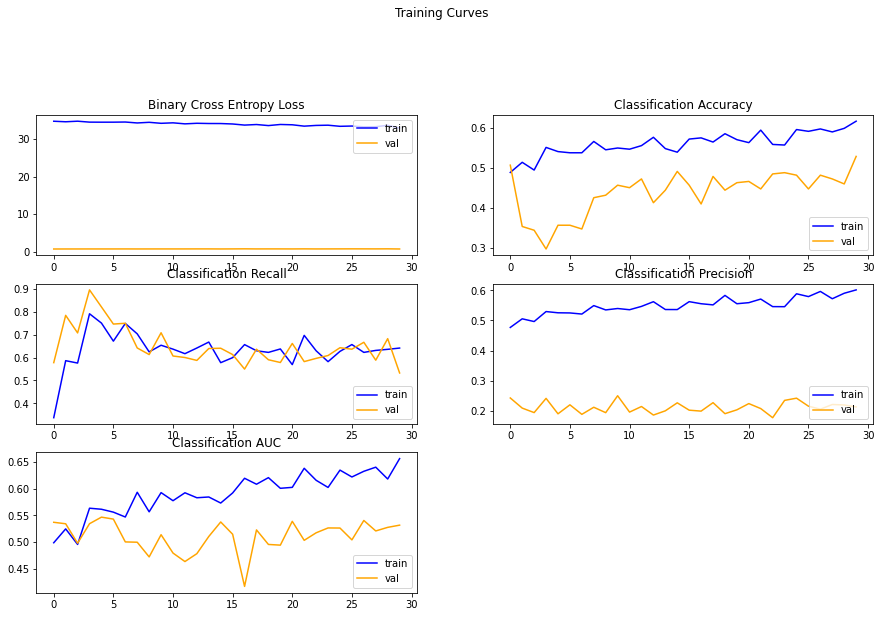

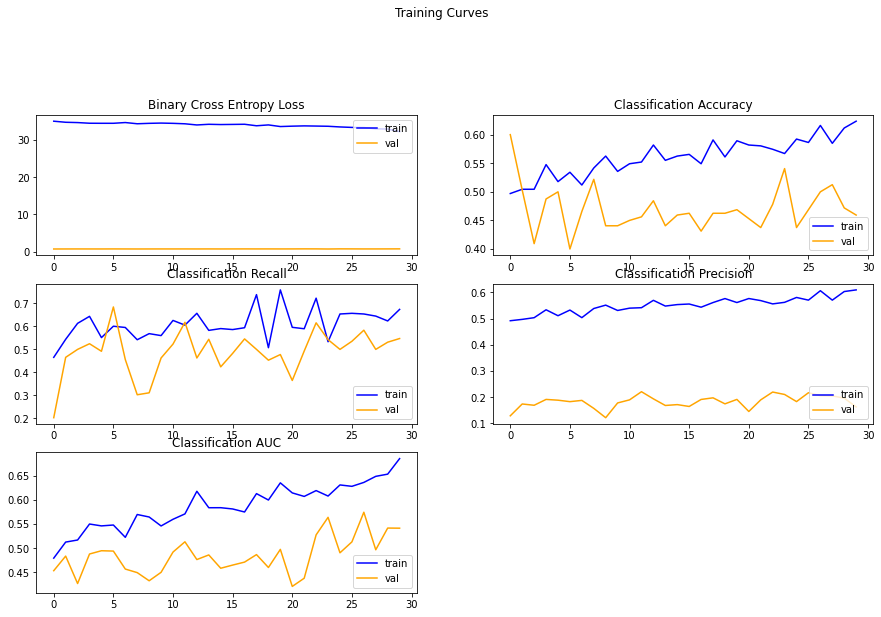

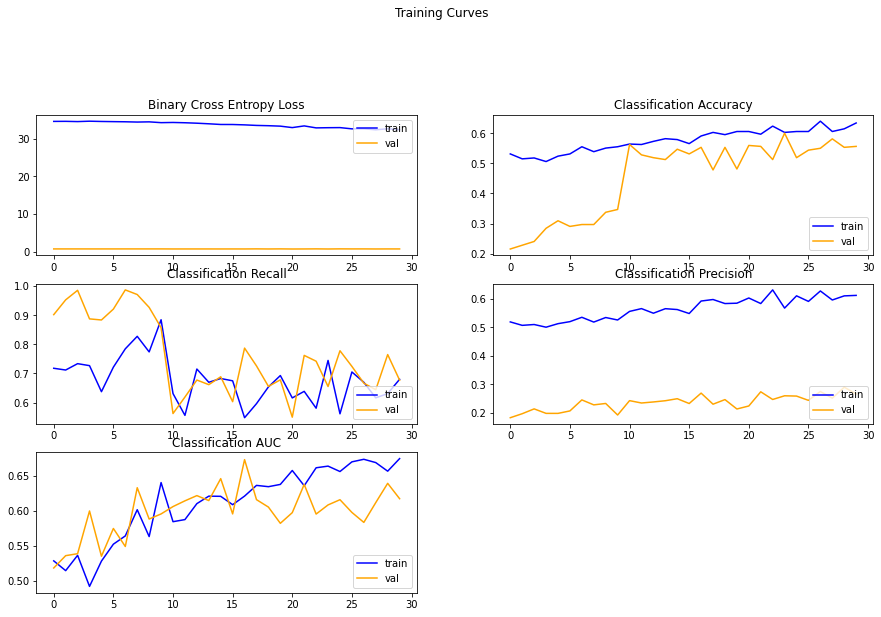

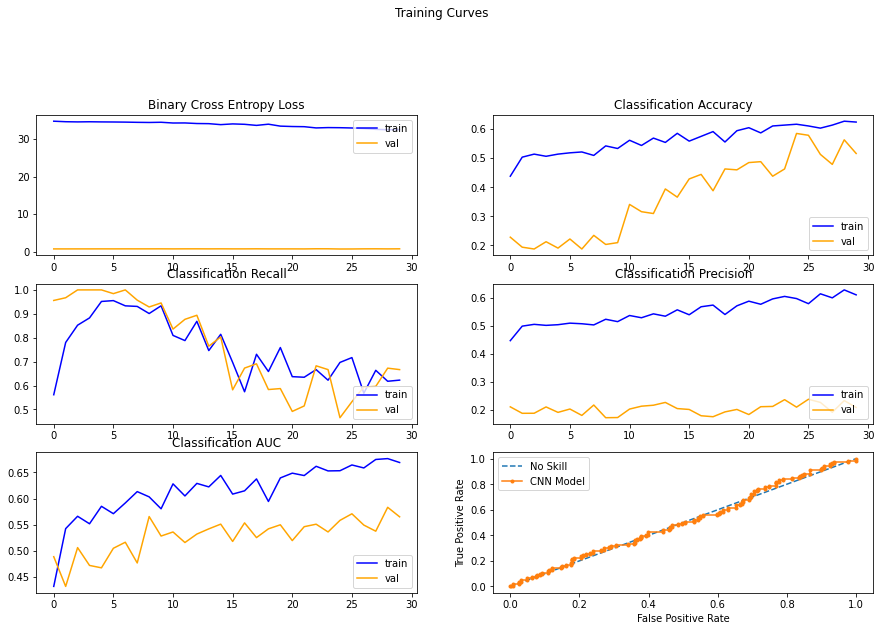

0.5088791674157528 AUC
Best Threshold=0.449767, G-Mean=1.053

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 1681 1681
Initial validation set 562 562
Initial test set 561 561
Initial train set: Negative samples: 1349 || Positive samples: 332 || Total_samples: 1681
Initial test set: Negative samples: 451 || Positive samples: 110 || Total_samples: 561
Initial validation set: Negative samples: 451 || Positive samples: 111 || Total_samples: 562
(562, 64, 64, 3)
(562, 100, 100, 3)
(561, 64, 64, 3)
(561, 100, 100, 3)
Train set contains 332 covid samples and 1349 non-covid samples
Number of negatives 337 Number of positives 332
w_0: 49.62630792227205
w_1: 50.37369207772795
(669, 64, 64, 3)
(669, 100, 100, 3)
Model: "sequential_44"
_______________

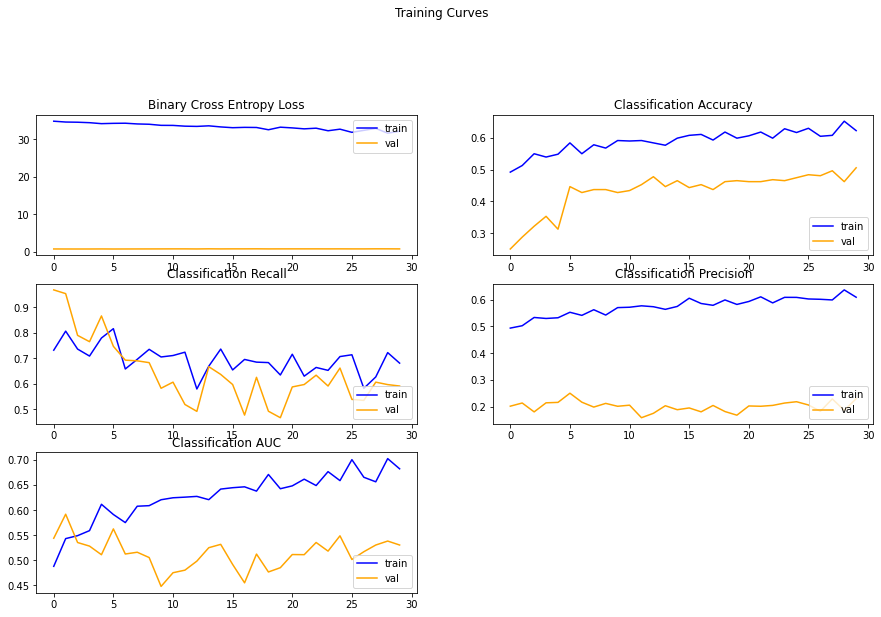

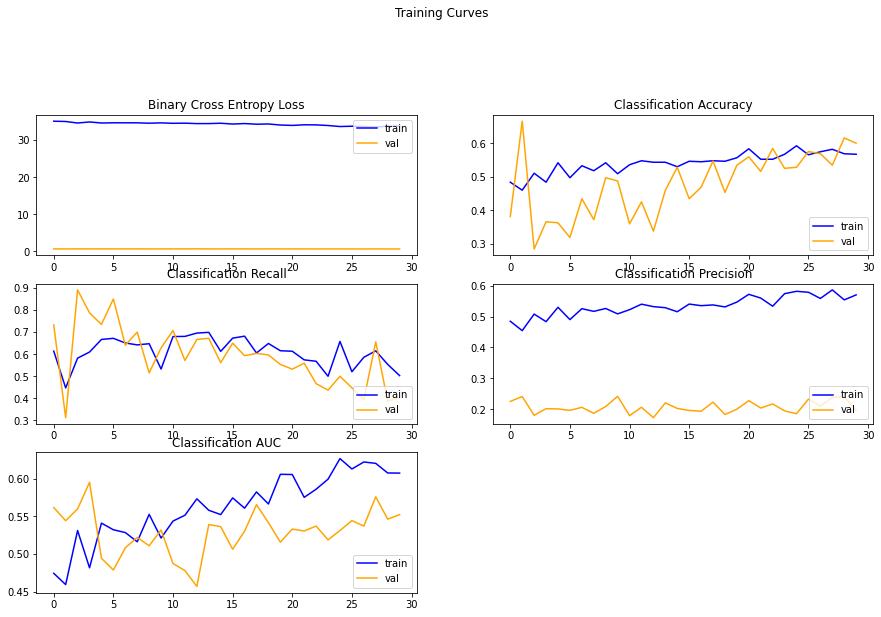

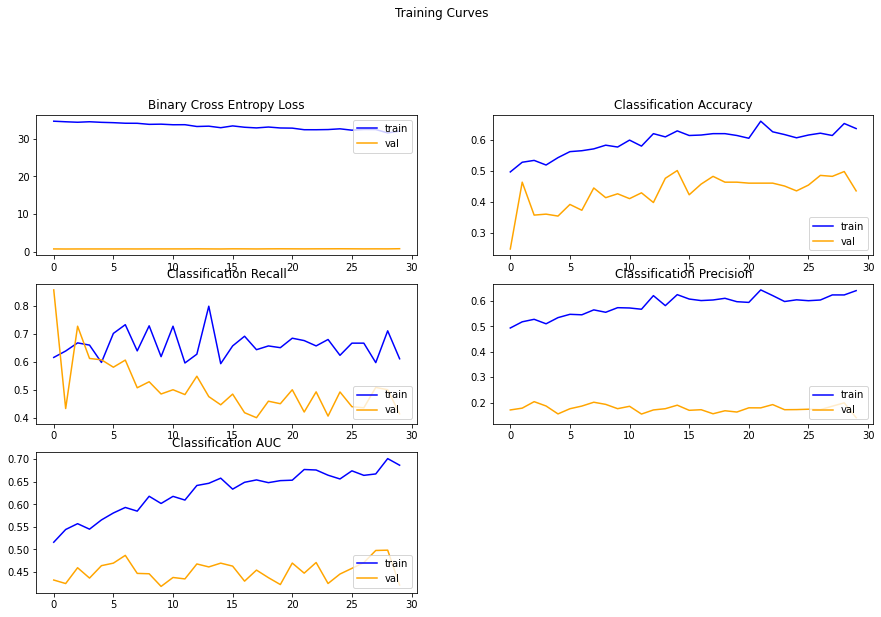

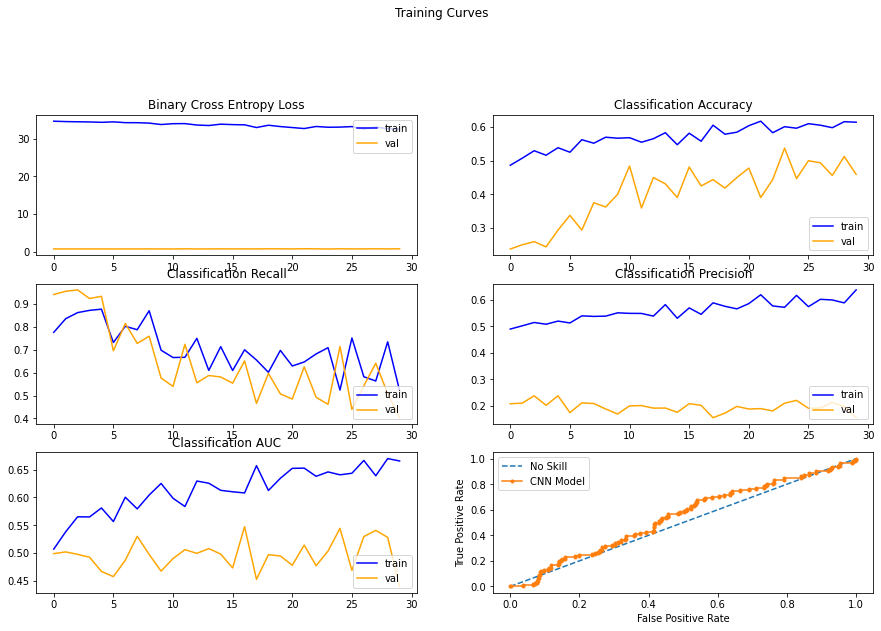

0.5423906470469664 AUC
Best Threshold=0.489185, G-Mean=1.132

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 1681 1681
Initial validation set 561 561
Initial test set 562 562
Initial train set: Negative samples: 1349 || Positive samples: 332 || Total_samples: 1681
Initial test set: Negative samples: 451 || Positive samples: 111 || Total_samples: 562
Initial validation set: Negative samples: 451 || Positive samples: 110 || Total_samples: 561
(561, 64, 64, 3)
(561, 100, 100, 3)
(562, 64, 64, 3)
(562, 100, 100, 3)
Train set contains 332 covid samples and 1349 non-covid samples
Number of negatives 337 Number of positives 332
w_0: 49.62630792227205
w_1: 50.37369207772795
(669, 64, 64, 3)
(669, 100, 100, 3)
Model: "sequential_48"
_______________

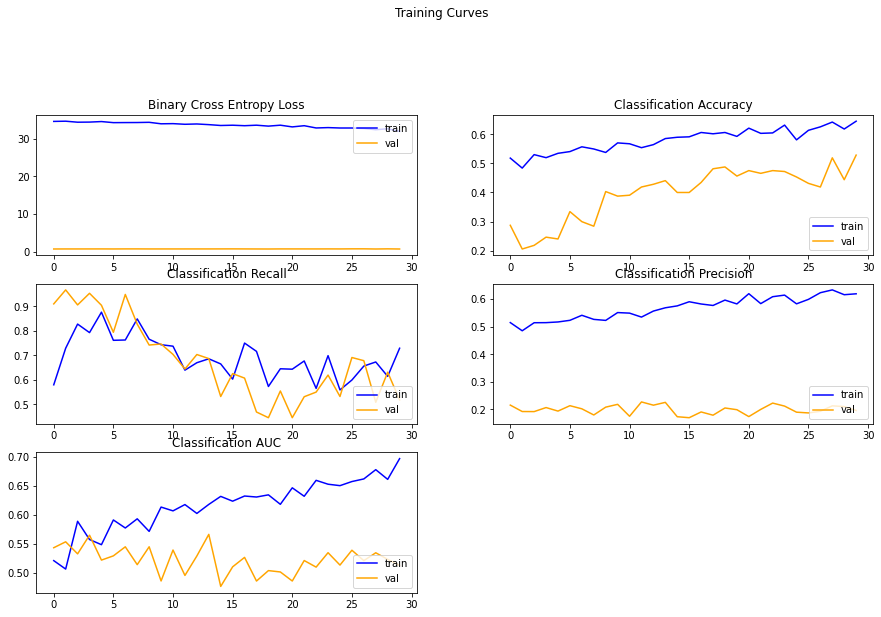

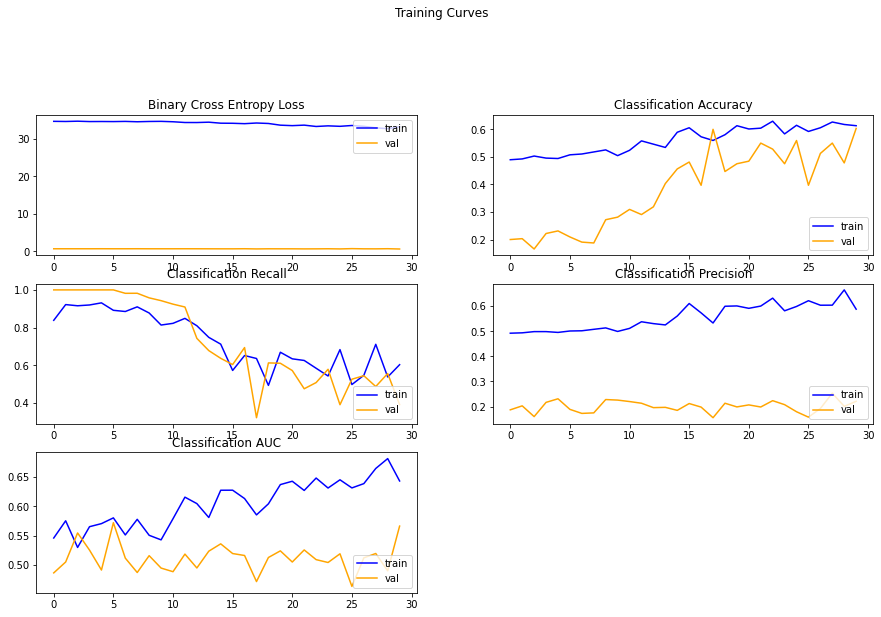

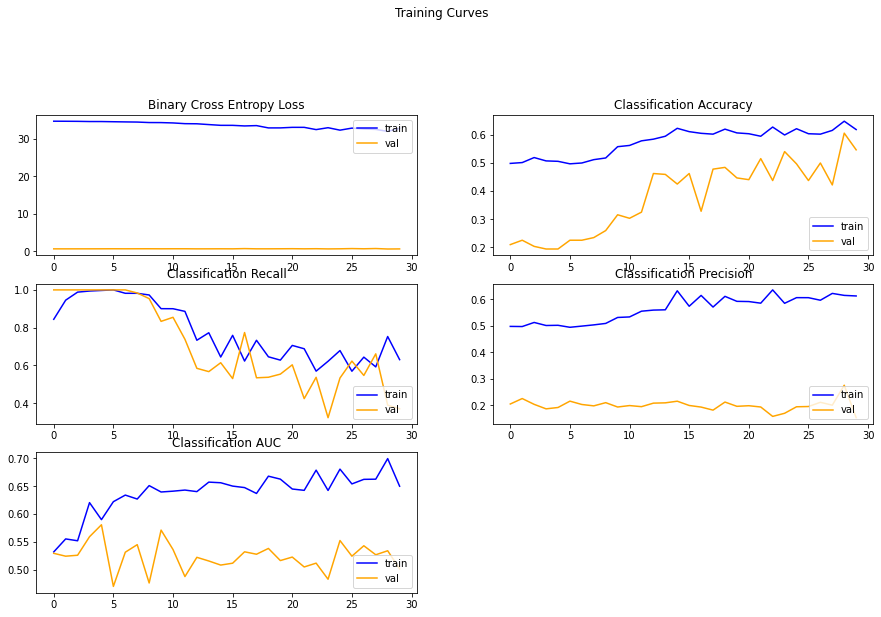

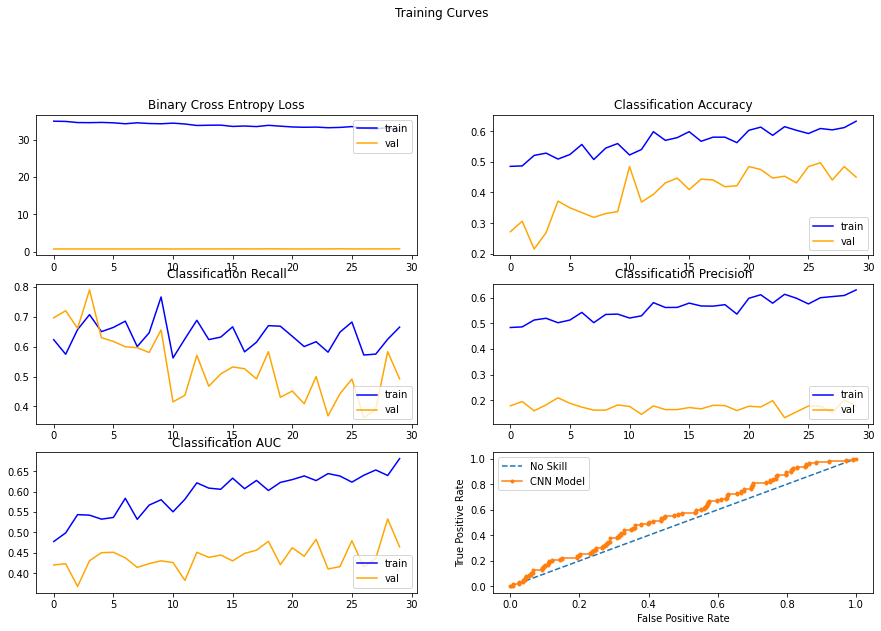

0.5669283474161523 AUC
Best Threshold=0.518833, G-Mean=1.118

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 1680 1680
Initial validation set 562 562
Initial test set 562 562
Initial train set: Negative samples: 1349 || Positive samples: 331 || Total_samples: 1680
Initial test set: Negative samples: 451 || Positive samples: 111 || Total_samples: 562
Initial validation set: Negative samples: 451 || Positive samples: 111 || Total_samples: 562
(562, 64, 64, 3)
(562, 100, 100, 3)
(562, 64, 64, 3)
(562, 100, 100, 3)
Train set contains 331 covid samples and 1349 non-covid samples
Number of negatives 337 Number of positives 331
w_0: 49.550898203592816
w_1: 50.449101796407184
(668, 64, 64, 3)
(668, 100, 100, 3)
Model: "sequential_52"
_____________

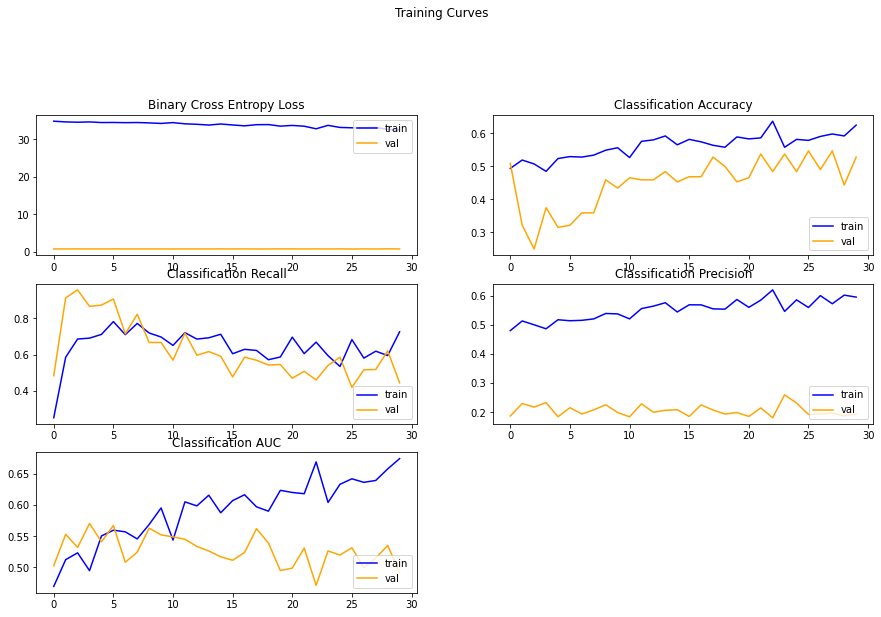

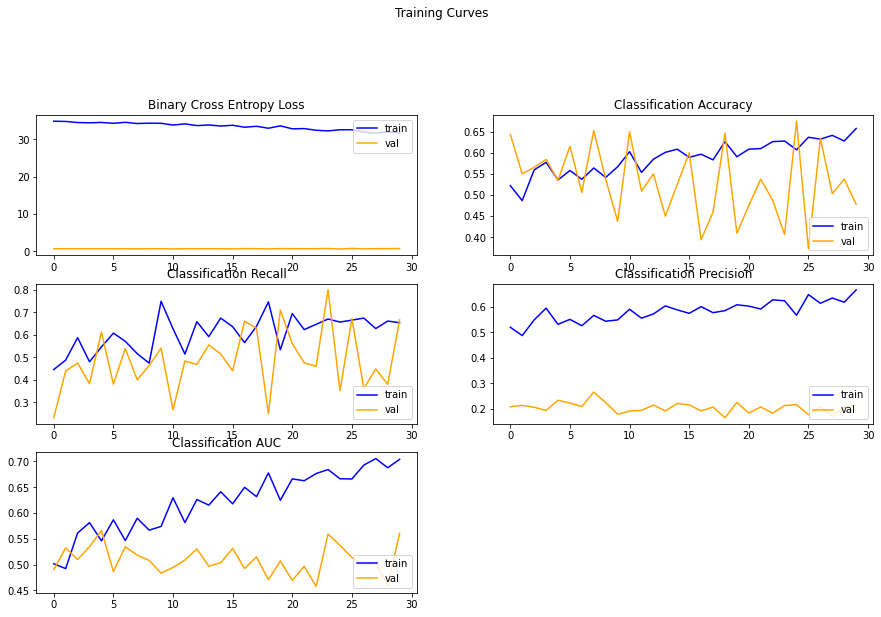

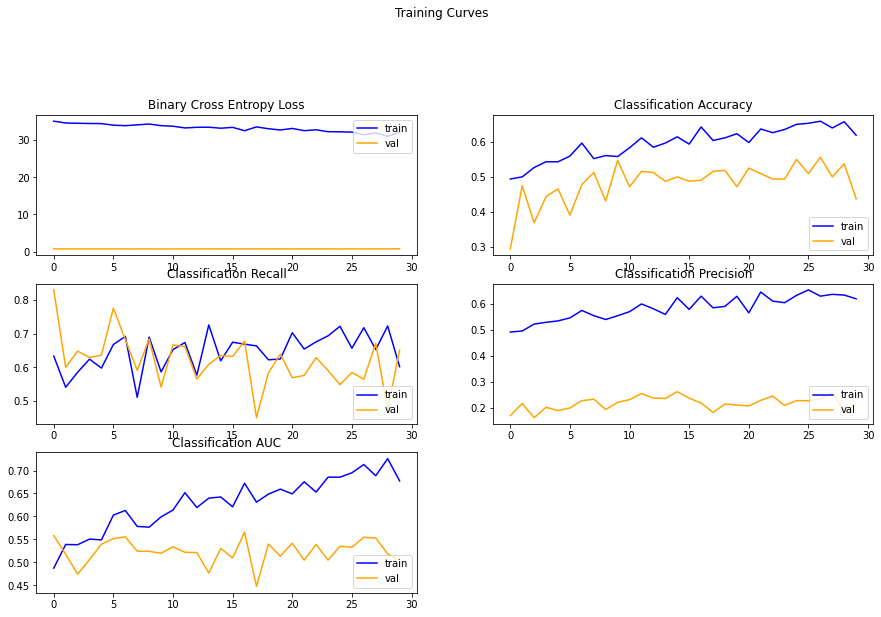

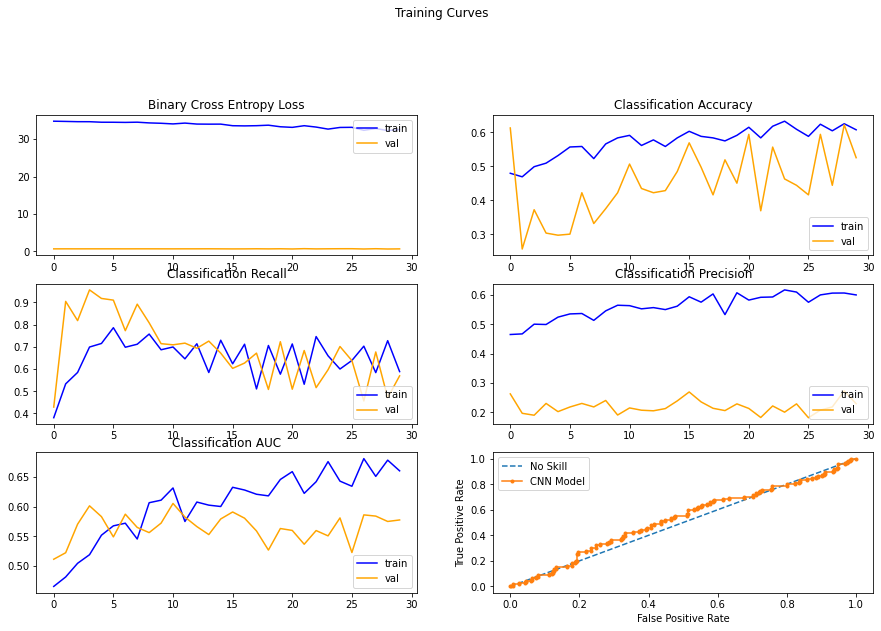

0.5271568686202832 AUC
Best Threshold=0.484056, G-Mean=1.086

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 1685 1685
Initial validation set 562 562
Initial test set 557 557
Initial train set: Negative samples: 1353 || Positive samples: 332 || Total_samples: 1685
Initial test set: Negative samples: 447 || Positive samples: 110 || Total_samples: 557
Initial validation set: Negative samples: 451 || Positive samples: 111 || Total_samples: 562
(562, 64, 64, 3)
(562, 100, 100, 3)
(557, 64, 64, 3)
(557, 100, 100, 3)
Train set contains 332 covid samples and 1353 non-covid samples
Number of negatives 338 Number of positives 332
w_0: 49.55223880597015
w_1: 50.44776119402985
(670, 64, 64, 3)
(670, 100, 100, 3)
Model: "sequential_56"
_______________

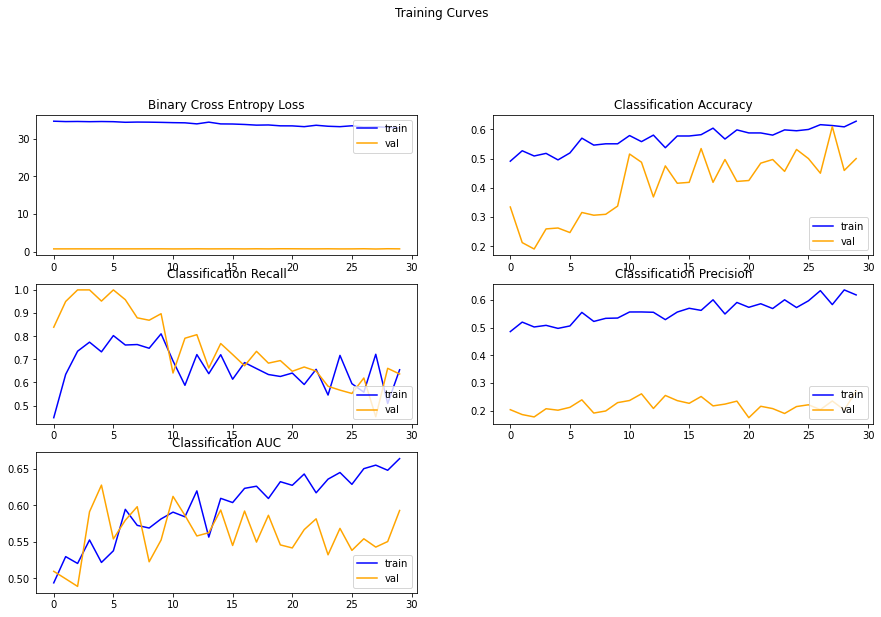

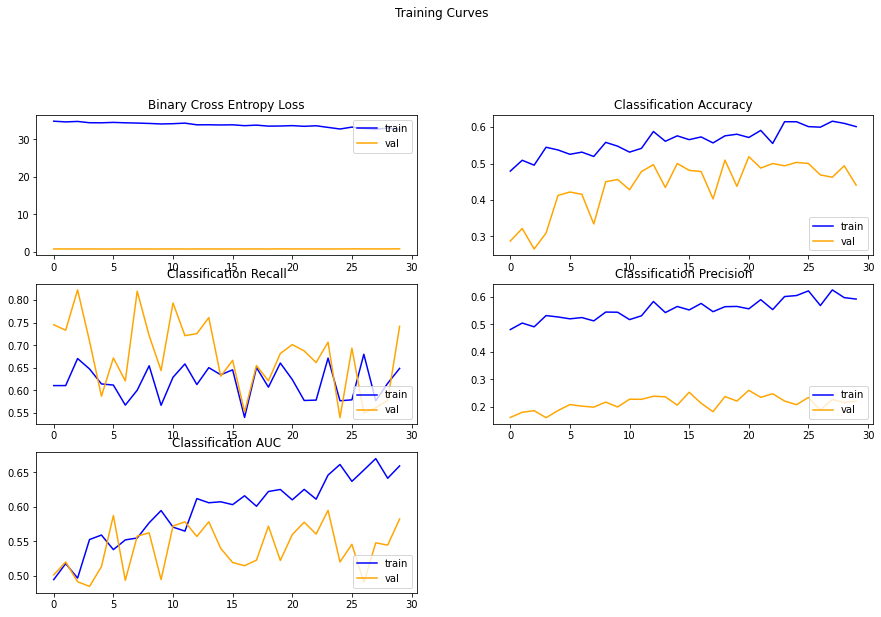

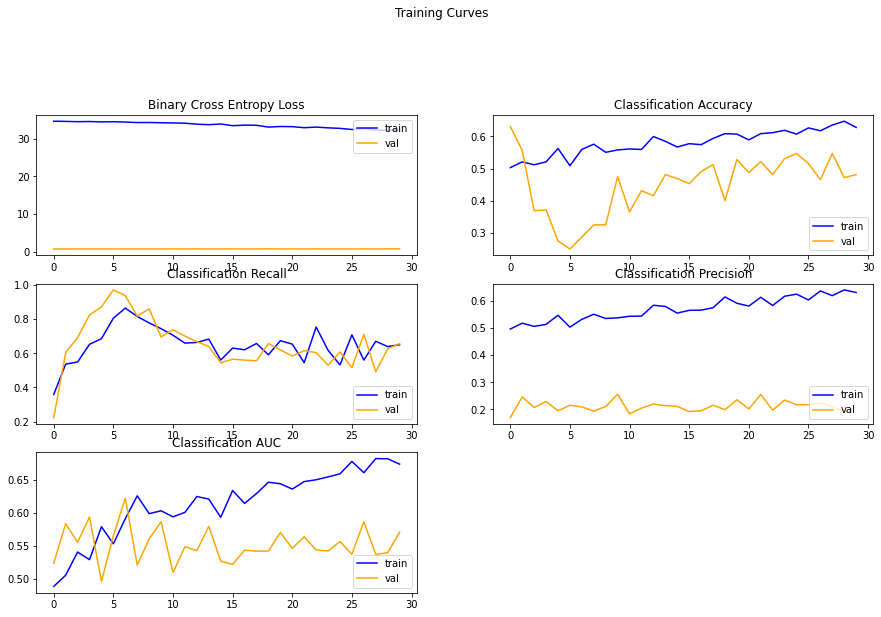

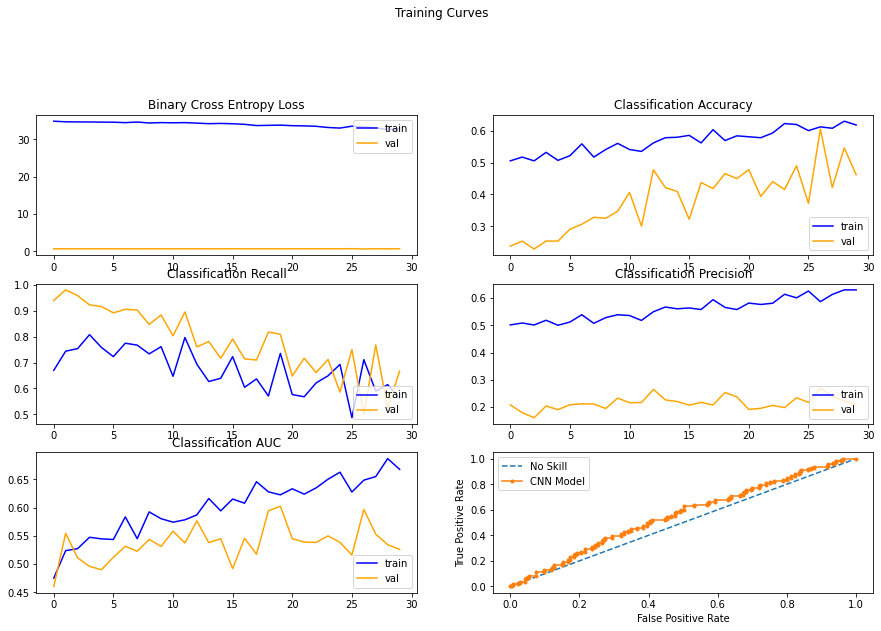

0.5585926377872686 AUC
Best Threshold=0.522102, G-Mean=1.126

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Accuracy: 49.383 %
Recall: 58.4275 %
Precision: 21.3946 %
AUC: 54.079 %
Specificity: 47.1604 %


In [ ]:
PRED, ACTUAL = train_with_5_folds_ensemble(splitted_folds)

## Hosmer-Lemeshow test
`data.json` files contain predicted and actual values for each sample of the test set, for each one of the five different splits of the dataset resulting from the 5-fold cross validation. These values are given as input to the following R code, to calculate the Hosmer-Lemeshow test statistic of the model.


```
library(ResourceSelection)
hl <- hoslem.test(x, y, g=10)
hl          
```

where x contains the predicted values and y the actual values of one of the 5 iterations

In [ ]:
y_pred = []
for i in ACTUAL:
  preds = []
  for j in i:
    preds.append(j[0])
  y_pred.append(preds)

In [ ]:
prs = []
for j in range(5):
  tmp2 = []
  tmp1 = calculate_mean_probabilities(PRED[j])
  pr = get_total_predictions(tmp1, 0.5)
  prs.append(list(pr))

In [ ]:
mydict = {"Predicted": prs[0], "Actual": y_pred[0]}
with open('data1.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[1], "Actual": y_pred[1]}
with open('data2.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[2], "Actual": y_pred[2]}
with open('data3.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[3], "Actual": y_pred[3]}
with open('data4.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[4], "Actual": y_pred[4]}
with open('data5.json', 'w') as fp:
    json.dump(str(mydict), fp)

# CAMBRIDGE dataset

## Prepare data

In [ ]:
csv_path = 'Cambridge_labels.csv' # path to labels csv

labels_dict_cambridge = {}
with open(csv_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      if row[1] == 'neg':
        labels_dict_cambridge[row[0]] = [0.0]
      elif row[1] == 'pos':
        labels_dict_cambridge[row[0]] = [1.0]

In [ ]:
image_path = "Cambridge/Cambridge/" + transform_name + "/" # path to images
input_arr_cambridge = []
labels_arr_cambridge = []
names_arr_cambridge = []

for i in os.listdir(image_path):
  if i in labels_dict_cambridge.keys():
    image = tf.keras.preprocessing.image.load_img(image_path + i, color_mode = 'rgb', target_size = (32,32,3))
    labels_arr_cambridge.append(labels_dict_cambridge[i])
    input_arr_cambridge.append(tf.keras.preprocessing.image.img_to_array(image))
    names_arr_cambridge.append(i)

In [ ]:
input_arr_cambridge = np.array(input_arr_cambridge)
labels_arr_cambridge = np.array(labels_arr_cambridge)

In [ ]:
tmp = list(zip(input_arr_cambridge, labels_arr_cambridge, names_arr_cambridge))

random.Random(0).shuffle(tmp)

input_arr_cambridge, labels_arr_cambridge, names_arr_cambridge = zip(*tmp)
input_arr_cambridge = np.array(input_arr_cambridge)
labels_arr_cambridge = np.array(labels_arr_cambridge)

In [ ]:
data_size, img_rows, img_cols, img_channels = input_arr_cambridge.shape

In [ ]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 32
IMG_SHAPE = (img_rows, img_cols, img_channels)
threshold = 0.5
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

## Functions used during training and testing

In [ ]:
def train_model(model, train_ds, validation_ds, weights, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, class_weight = weights)
  return(history)

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  plt.figure(figsize=(15, 15))
  plt.suptitle('Training Curves')
  # plot loss
  
  plt.subplot(521)
  plt.title('Binary Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
  plt.legend(loc='upper right')
  # plot accuracy
  plt.subplot(522)
  plt.title('Classification Accuracy')
  plt.plot(history.history['Accuracy'], color='blue', label='train')
  plt.plot(history.history['val_Accuracy'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(523)
  plt.title('Classification Recall')
  plt.plot(history.history['Recall'], color='blue', label='train')
  plt.plot(history.history['val_Recall'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(524)
  plt.title('Classification Precision')
  plt.plot(history.history['Precision'], color='blue', label='train')
  plt.plot(history.history['val_Precision'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(525)
  plt.title('Classification AUC')
  plt.plot(history.history['AUC'], color='blue', label='train')
  plt.plot(history.history['val_AUC'], color='orange', label='val')
  plt.legend(loc='lower right')
  return plt

In [ ]:
def evaluate_trained_model(x_test, y_test, new_model, steps_per_epoch = 10):
    loss, recall, precision, auc, acc, tp, fp, fn, tn = new_model.evaluate(x_test, y_test, steps = steps_per_epoch)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print('Restored model, recall: {:5.2f}%'.format(100 * recall))
    print('Restored model, precision: {:5.2f}%'.format(100 * precision))
    print('Restored model, Specificity: ', (tn/(tn+fp))*100)
    print('Restored model, AUC: {:5.2f}%'.format(100 * auc))
    
    print('Restored model, true positives: ', tp)
    print('Restored model, false positives: ', fp)
    print('Restored model, false negatives: ', fn)
    print('Restored model, true negatives: ', tn)
    
    return recall, precision, auc, acc, tp, fp, fn, tn

In [ ]:
def get_predictions(model, x_test, y_test, threshold, steps_per_epoch):
    pred=model.predict(x_test, steps = steps_per_epoch)
    
    probabilities = []
    predictions = []
    for i in pred:
        if i[0] >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
    for i in pred:
        probabilities.append(i[0])
    
    return probabilities, predictions, pred

In [ ]:
def print_average_results(probabilities_list, y_test, threshold):
    probabilities = calculate_mean_probabilities(probabilities_list)
    predictions = get_total_predictions(probabilities, threshold)
    (acc, recall, precision, auc, specificity)  = calculate_metrics(predictions, probabilities, y_test, threshold)
    tpr, fpr, thresholds = plot_roc(y_test, probabilities)
    return (acc, recall, precision, auc, specificity)  


def calculate_mean_probabilities(probabilities_list):
  probabilities = []
  
  for i in range(len(probabilities_list[0])):
    mean_probability = np.mean([probabilities_list[0][i], probabilities_list[1][i]])
    probabilities.append([mean_probability])
  
  probabilities = np.array(probabilities)
  return probabilities

def get_total_predictions(probabilities, threshold):
  predictions = []
  for i in probabilities:
    if i[0] >= threshold:
      predictions.append(1.0)
    elif i[0] < threshold:
      predictions.append(0.0)
  
  predictions = np.array(predictions)
  return predictions

def calculate_metrics(predictions, probabilities, y_test, threshold):
  acc = accuracy_score(y_test, predictions)*100
  recall = recall_score(y_test, predictions, zero_division = 0)*100
  precision  = precision_score(y_test, predictions, zero_division = 0)*100
  auc = roc_auc_score(y_test, probabilities)*100
  tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
  specificity = tn / (tn+fp)
  print("Accuracy: ", acc, "%")
  print("Recall: ", recall, "%")
  print("Precision: ",precision, "%")
  print("AUC: ",auc, "%")
  print("Specificity: ", specificity*100, "%")

  return (acc, recall, precision, auc, specificity*100)          

In [ ]:
# Plot ROC curve

def plot_roc(y_true, probabilities):
    y_true_int = []
    for i in y_true:
        y_true_int.append(int(i))

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_true_int, probabilities)
    # plot the roc curve for the model
    plt.subplot(526)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='CNN Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    print(roc_auc_score(y_true_int, probabilities), "AUC")
    return tpr, fpr, thresholds

In [ ]:
def calculate_weights(y_train):
    no_neg = 0
    no_pos = 0
    for i in y_train:
        if i[0] == 0.0:
            no_neg = no_neg + 1
        else:
            no_pos = no_pos + 1
    print("Train set in use: Number of negatives:", no_neg, "|| Number of positives:", no_pos)

    ratio = (no_pos*100)/(no_neg+no_pos)
    w_0 = ratio
    w_1 = 100-ratio
    print("w_0:", w_0)
    print("w_1:", w_1)

    # Give class weights
    class_weight = {0: w_0,
                    1: w_1}
    return class_weight

In [ ]:
def _input_fn(x, y, BATCH_SIZE, data_size, IMG_SIZE): ### to data size prostethike meta

  x_reshaped = []
  print(x.shape)
  for i in x:
    x_reshaped.append(tf.image.resize(i, IMG_SIZE))
  x_reshaped = np.array(x_reshaped)
  print(x_reshaped.shape)
  ds = tf.data.Dataset.from_tensor_slices((x_reshaped,y)) 
  ds = ds.shuffle(buffer_size=data_size) # https://datascience.stackexchange.com/questions/89316/tensorflows-shufflebuffer-size
  ds = ds.repeat() # https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
def ensemble_split(x_train, y_train):
  neg = 0
  pos = 0

  x_train_set = []
  y_train_set = []

  tmp_1x = []
  tmp_2x = []

  tmp_1y = []
  tmp_2y = []

  tmp_x = []
  tmp_y = []
  
  for i in y_train:
    if i[0] == 0.0:
      neg = neg + 1
    else:
      pos = pos + 1

  print("Initial train set contains", pos, "covid samples and", neg, "non-covid samples")
  neg_samples = round(neg/2)

  train_neg = []
  train_pos = []
  index = 0

  for i in y_train:
    if i[0] == 0.0:
      train_neg.append(index)
    elif i[0] == 1.0:
      train_pos.append(index)
    index = index + 1
  
  index_1 = train_neg[0:neg_samples]
  index_2 = train_neg[neg_samples:]

  for i in index_1:
    tmp_1x.append(x_train[i])
    tmp_1y.append(y_train[i])

  for i in index_2:
    tmp_2x.append(x_train[i])
    tmp_2y.append(y_train[i])
  
  for i in train_pos:
    tmp_x.append(x_train[i])
    tmp_y.append(y_train[i])

  tmp_x = np.array(tmp_x)
  tmp_y  = np.array(tmp_y)

  tmp_1x = np.array(tmp_1x)
  tmp_2x = np.array(tmp_2x)

  tmp_1y = np.array(tmp_1y)
  tmp_2y = np.array(tmp_2y)

  x_train_set.append(np.concatenate((tmp_1x,tmp_x), axis = 0))
  x_train_set.append(np.concatenate((tmp_2x,tmp_x), axis = 0))

  y_train_set.append(np.concatenate((tmp_1y,tmp_y), axis = 0))
  y_train_set.append(np.concatenate((tmp_2y,tmp_y), axis = 0))

  return x_train_set, y_train_set

In [ ]:
def train_with_5_folds_ensemble(splitted_folds):
  PROBABILITIES_LIST = []
  PREDICTIONS_LIST = []
  ACCURACY = []
  RECALL = []
  PRECISION = []
  AUC = []
  SPECIFICITY = []
  ACTUAL = []
  PREDICTIONS = []
  new_m = []
  j = 0

  for fold in splitted_folds:

    X_train = []
    X_val = []
    X_test = []

    y_train = []
    y_val = []
    y_test = []


    for files in fold[0]:
      X_train.append(input_arr_cambridge[files]/255.0)
      y_train.append(labels_arr_cambridge[files])
    for files in fold[1]:
      X_val.append(input_arr_cambridge[files]/255.0)
      y_val.append(labels_arr_cambridge[files])
    for files in fold[2]:
      X_test.append(input_arr_cambridge[files]/255.0)
      y_test.append(labels_arr_cambridge[files])


    print("Initial train set", len(X_train), len(y_train))
    print("Initial validation set", len(X_val), len(y_val))
    print("Initial test set", len(X_test), len(y_test))
    
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)

    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    neg = 0 
    pos = 0
    for i in y_test:
      if i[0] == 1.0:
        pos = pos + 1
      elif i[0] == 0.0:
        neg = neg + 1

    print("Initial test set: Negative samples:", neg, "|| Positive samples:", pos, "|| Total_samples:", neg+pos) 

    neg = 0 
    pos = 0
    for i in y_val:
      if i[0] == 1.0:
        pos = pos + 1
      elif i[0] == 0.0:
        neg = neg + 1

    print("Initial validation set: Negative samples:", neg, "|| Positive samples:", pos, "|| Total_samples:", neg+pos)

    (PRED, test, acc, recall, precision, auc, specificity, m) = train_with_ensemble(X_train, y_train, X_val, y_val, X_test, y_test)
    new_m.append(m)
    j = j + 1
    RECALL.append(recall)
    PRECISION.append(precision)
    AUC.append(auc)
    ACCURACY.append(acc)
    SPECIFICITY.append(specificity)
    PREDICTIONS.append(PRED)
    ACTUAL.append(test)


  print("Accuracy:", round(np.mean(ACCURACY),4), "%")
  print("Recall:", round(np.mean(RECALL),4), "%")
  print("Precision:", round(np.mean(PRECISION),4), "%")
  print("AUC:", round(np.mean(AUC),4), "%")
  print("Specificity:", round(np.mean(SPECIFICITY),4), "%")

  return PREDICTIONS, ACTUAL

In [ ]:
def train_with_ensemble(X_train, y_train, X_val, y_val, X_test, y_test):
    img = 100
    IMG_SHAPE = (img, img, 3)
    new_models = []
    validation_ds =_input_fn(X_val,y_val, BATCH_SIZE, data_size, (img,img)) #PrefetchDataset object

    test_ds =_input_fn(X_test, y_test, BATCH_SIZE, data_size, (img,img)) #PrefetchDataset object

    x_train_set, y_train_set = ensemble_split(X_train, y_train)

    x_reshaped = []
    for i in X_test:
      x_reshaped.append(tf.image.resize(i, (img, img)))
    x_reshaped = np.array(x_reshaped)

    PROBABILITIES_LIST = []
    PREDICTIONS_LIST = []
    for i in range(len(x_train_set)):
      weights = calculate_weights(y_train_set[i])

      test_steps = int(len(y_test)/BATCH_SIZE)
      train_ds =_input_fn(x_train_set[i], y_train_set[i], BATCH_SIZE, data_size, (img,img)) #PrefetchDataset object
      
      model = init_model_2(True, IMG_SHAPE)
      model_history = train_model(model, train_ds, validation_ds, weights, 30, int(len(y_train_set[i])/BATCH_SIZE), 10)
    
      summarize_diagnostics(model_history)

      recall, precision, auc, acc, tp, fp, fn, tn = evaluate_trained_model(x_reshaped, y_test, model, steps_per_epoch = test_steps)
      
      probabilities, predictions, pred = get_predictions(model, x_reshaped, y_test, threshold, test_steps)

      PROBABILITIES_LIST.append(probabilities)
      PREDICTIONS_LIST.append(predictions)
      new_models.append(model)
      
    (acc, recall, precision, auc, specificity) = print_average_results(PROBABILITIES_LIST, y_test, threshold)
    print()

    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    return (PROBABILITIES_LIST, y_test, acc, recall, precision, auc,specificity, new_models)  

In [ ]:
def folds_split_Cambridge_stratified():
  folds_split = 0.2

  folds = [[], [], [], [], []]

  ###folds contain indices
  ind_flag = [0] * len(names_arr_cambridge)

  cnt = 0 
  x = folds_split

  non_covid = 0
  covid = 0

  for file in labels_arr_cambridge:
    if file == [0.0]:
      non_covid = non_covid + 1
    else:
      covid = covid + 1

  non_covid_percentage = non_covid/(covid + non_covid)
  covid_percentage = covid/(covid + non_covid)

  print("Non covid percentage:", non_covid_percentage)
  print("Covid percentage:", covid_percentage)


  for i in range(5):
    neg = 0
    pos = 0
    while len(folds[i]) < folds_split*data_size :
      for ind in range(data_size):
        if ind_flag[ind] == 0:
          if len(names_arr_cambridge[ind].split("_")) ==  3: # ---> android files' format (only android files have many samples from the same user)
            indices = [j for j, s in enumerate(names_arr_cambridge) if names_arr_cambridge[ind].split(".")[0].split("_")[1] in s]
            if i!=4 and (labels_arr_cambridge[ind] == [0.0] and neg<=non_covid_percentage*folds_split*data_size) or (labels_arr_cambridge[ind] == [1.0] and pos<=covid_percentage*folds_split*data_size):
              for inds in indices:
                
                if labels_arr_cambridge[inds] == [0.0]:
                  neg = neg + 1
                else:
                  pos = pos + 1
                
                folds[i].append(inds)
                ind_flag[inds] = 1
              cnt = cnt + len(indices)
            elif i==4 :
              for inds in indices:
                
                if labels_arr_cambridge[inds] == [0.0]:
                  neg = neg + 1
                else:
                  pos = pos + 1
                
                folds[i].append(inds)
                ind_flag[inds] = 1
              cnt = cnt + len(indices)

            else:
              continue
          else:
            
            indices = [j for j, s in enumerate(names_arr_cambridge) if names_arr_cambridge[ind].split(".")[0].split("_")[1] + "_" + names_arr_cambridge[ind].split(".")[0].split("_")[2] + "_" + names_arr_cambridge[ind].split(".")[0].split("_")[3] + "_" + names_arr_cambridge[ind].split(".")[0].split("_")[4] in s]

            if i!=4 and (labels_arr_cambridge[ind] == [0.0] and neg<=non_covid_percentage*folds_split*data_size) or (labels_arr_cambridge[ind] == [1.0] and pos<=covid_percentage*folds_split*data_size):
              for inds in indices:
                
                if labels_arr_cambridge[inds] == [0.0]:
                  neg = neg + 1
                else:
                  pos = pos + 1
                folds[i].append(inds)
                ind_flag[inds] = 1
              cnt = cnt + len(indices)
            elif i==4:
              
              for inds in indices:
                
                if labels_arr_cambridge[inds] == [0.0]:
                  neg = neg + 1
                else:
                  pos = pos + 1
                folds[i].append(inds)
                ind_flag[inds] = 1
              cnt = cnt + len(indices)
            else:
              continue

        if len(folds[i]) >= folds_split*data_size:
          break
      if i == 4 and cnt == data_size:
        break
    
  return folds

## Training and testing

In [ ]:
folds = folds_split_Cambridge_stratified()

Non covid percentage: 0.69
Covid percentage: 0.31


In [ ]:
for f in folds:
  neg = 0
  pos = 0
  for ff in f:
    if labels_arr_cambridge[ff] == [0.0]:
      neg = neg + 1
    else:
      pos =pos + 1
  print("Negative:", neg/(neg+pos), "positive:", pos/(neg+pos))
  print("-------------------------------------------------------")

Negative: 0.6829268292682927 positive: 0.3170731707317073
-------------------------------------------------------
Negative: 0.6625 positive: 0.3375
-------------------------------------------------------
Negative: 0.6 positive: 0.4
-------------------------------------------------------
Negative: 0.7 positive: 0.3
-------------------------------------------------------
Negative: 0.8076923076923077 positive: 0.19230769230769232
-------------------------------------------------------


In [ ]:
for f in folds[0]:
  if f in folds[1] or f in folds[2] or f in folds[3] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[1]:
  if f in folds[0] or f in folds[2] or f in folds[3] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[2]:
  if f in folds[0] or f in folds[1] or f in folds[3] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[3]:
  if f in folds[0] or f in folds[1] or f in folds[2] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[4]:
  if f in folds[0] or f in folds[1] or f in folds[2] or f in folds[3]:
    print("The same sample exists in more than one folds")

In [ ]:
# concatenate folds to create 5 different splits of the dataset into train, validation and test set

tmp = []
splitted_folds = []
for i in range(len(folds)):
  print(len(folds[i]))

tmp.append(list(folds[1]+folds[2]+folds[3])) # train
tmp.append(folds[4]) # validation
tmp.append(list(folds[0])) # test
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[0]+folds[2]+folds[4]))
tmp.append(folds[3])
tmp.append(list(folds[1]))
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[0]+folds[3]+folds[4]))
tmp.append(folds[1])
tmp.append(list(folds[2]))
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[1]+folds[2]+folds[4]))
tmp.append(folds[0])
tmp.append(list(folds[3]))
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[0]+folds[1]+folds[3]))
tmp.append(folds[2])
tmp.append(list(folds[4]))
splitted_folds.append(list(tmp))

82
80
80
80
78


In [ ]:
for f in splitted_folds:
  print("Train set contains", len(f[0]), "samples, validation set contains", len(f[1]), "samples, test set contains", len(f[2]), "samples")

Train set contains 240 samples, validation set contains 78 samples, test set contains 82 samples
Train set contains 240 samples, validation set contains 80 samples, test set contains 80 samples
Train set contains 240 samples, validation set contains 80 samples, test set contains 80 samples
Train set contains 238 samples, validation set contains 82 samples, test set contains 80 samples
Train set contains 242 samples, validation set contains 80 samples, test set contains 78 samples


In [ ]:
# statistics for each fold

for ff in folds:
  neg = 0
  pos = 0
  for i in ff:
    if labels_arr_cambridge[i] == [0.0]:
      neg = neg + 1
    else:
      pos = pos + 1
  print("Negative:", neg, "total", pos+neg, "Percentage:", (neg*100)/(neg+pos))
  print("Positive:", pos, "total", pos+neg, "Percentage:", (pos*100)/(neg+pos))
  print("------------------------------------------------------------------------")

Negative: 56 total 82 Percentage: 68.29268292682927
Positive: 26 total 82 Percentage: 31.70731707317073
------------------------------------------------------------------------
Negative: 53 total 80 Percentage: 66.25
Positive: 27 total 80 Percentage: 33.75
------------------------------------------------------------------------
Negative: 48 total 80 Percentage: 60.0
Positive: 32 total 80 Percentage: 40.0
------------------------------------------------------------------------
Negative: 56 total 80 Percentage: 70.0
Positive: 24 total 80 Percentage: 30.0
------------------------------------------------------------------------
Negative: 63 total 78 Percentage: 80.76923076923077
Positive: 15 total 78 Percentage: 19.23076923076923
------------------------------------------------------------------------


Initial train set 240 240
Initial validation set 78 78
Initial test set 82 82
Initial test set: Negative samples: 56 || Positive samples: 26 || Total_samples: 82
Initial validation set: Negative samples: 63 || Positive samples: 15 || Total_samples: 78
(78, 32, 32, 3)
(78, 100, 100, 3)
(82, 32, 32, 3)
(82, 100, 100, 3)
Initial train set contains 83 covid samples and 157 non-covid samples
Train set in use: Number of negatives: 78 || Number of positives: 83
w_0: 51.5527950310559
w_1: 48.4472049689441
(161, 32, 32, 3)
(161, 100, 100, 3)
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_195 (Conv2D)          (None, 96, 96, 4)         304       
_________________________________________________________________
dropout_260 (Dropout)        (None, 96, 96, 4)         0         
_________________________________________________________________
average_pooling2d_130 (Avera (None, 48, 48

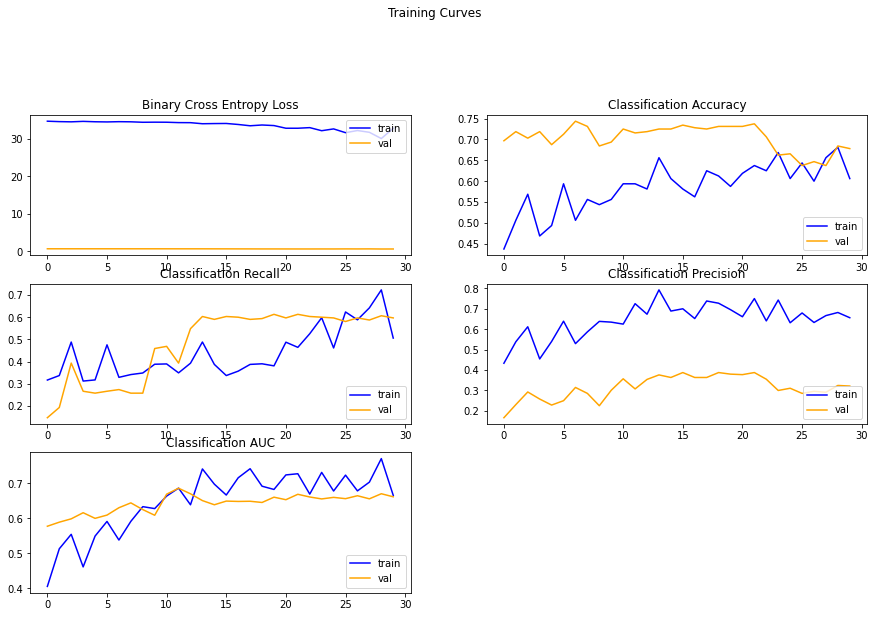

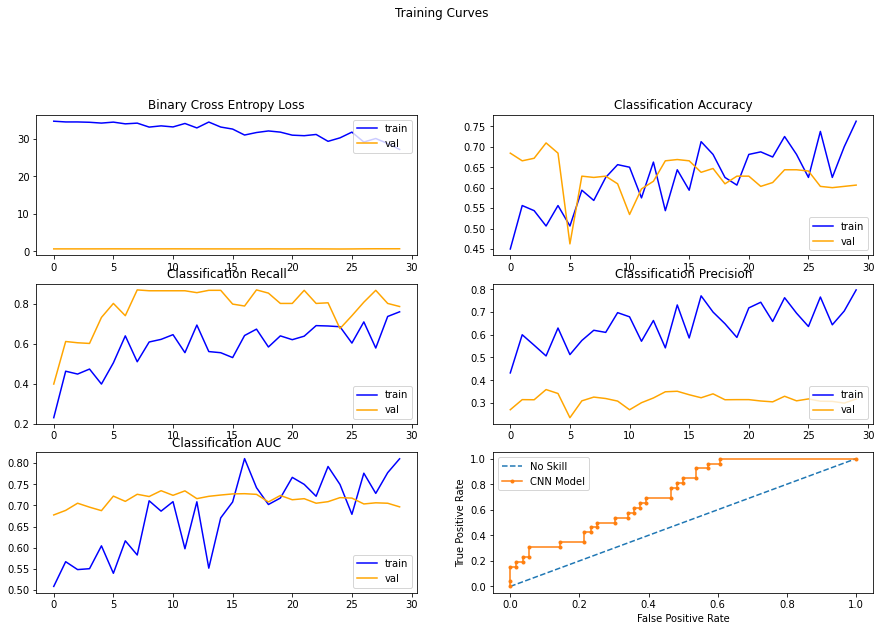

0.7252747252747254 AUC
Best Threshold=0.474062, G-Mean=1.393

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 240 240
Initial validation set 80 80
Initial test set 80 80
Initial test set: Negative samples: 53 || Positive samples: 27 || Total_samples: 80
Initial validation set: Negative samples: 56 || Positive samples: 24 || Total_samples: 80
(80, 32, 32, 3)
(80, 100, 100, 3)
(80, 32, 32, 3)
(80, 100, 100, 3)
Initial train set contains 73 covid samples and 167 non-covid samples
Train set in use: Number of negatives: 84 || Number of positives: 73
w_0: 46.496815286624205
w_1: 53.503184713375795
(157, 32, 32, 3)
(157, 100, 100, 3)
Model: "sequential_67"
_________________________________________________________________
Layer (type)              

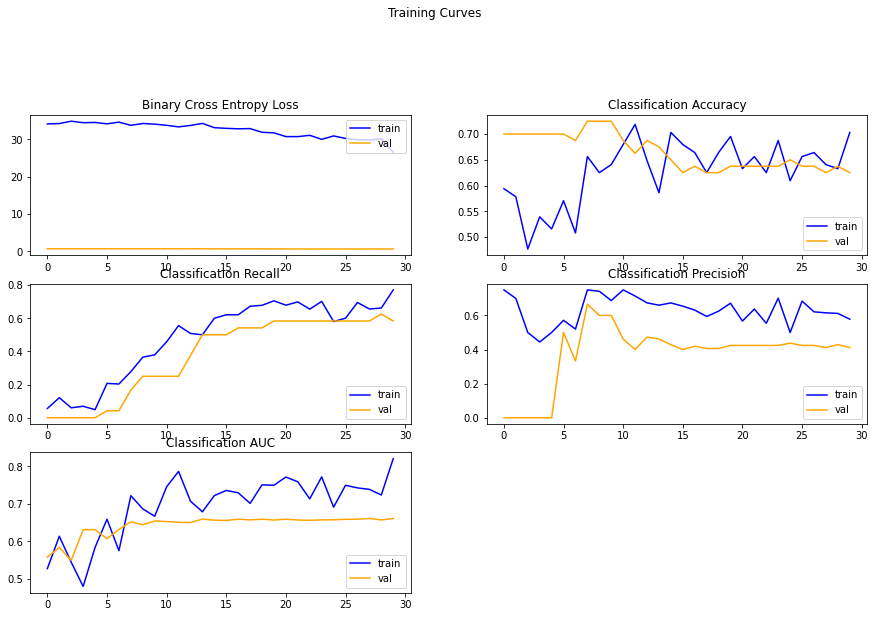

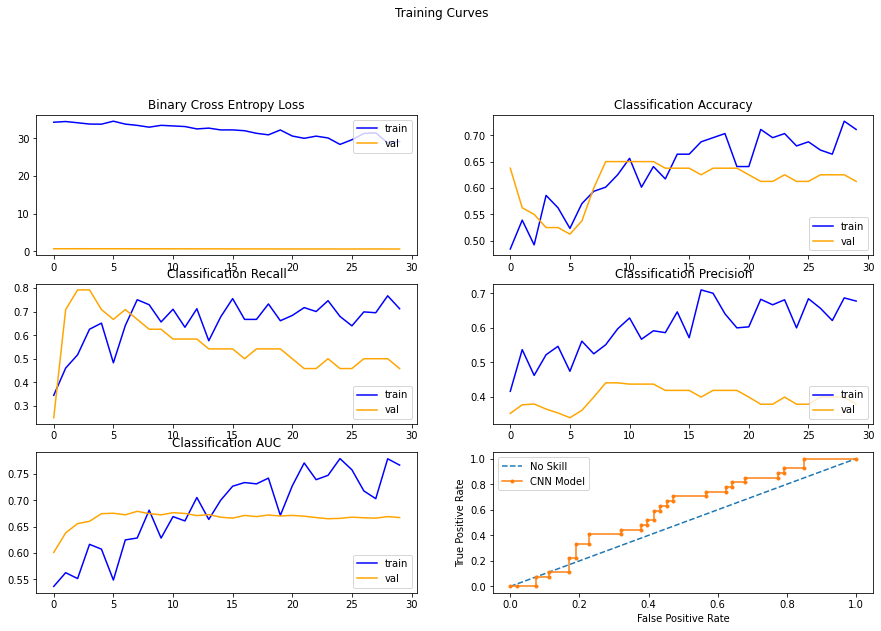

0.5981830887491264 AUC
Best Threshold=0.440735, G-Mean=1.232

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 240 240
Initial validation set 80 80
Initial test set 80 80
Initial test set: Negative samples: 48 || Positive samples: 32 || Total_samples: 80
Initial validation set: Negative samples: 53 || Positive samples: 27 || Total_samples: 80
(80, 32, 32, 3)
(80, 100, 100, 3)
(80, 32, 32, 3)
(80, 100, 100, 3)
Initial train set contains 65 covid samples and 175 non-covid samples
Train set in use: Number of negatives: 88 || Number of positives: 65
w_0: 42.48366013071895
w_1: 57.51633986928105
(153, 32, 32, 3)
(153, 100, 100, 3)
Model: "sequential_69"
_________________________________________________________________
Layer (type)                

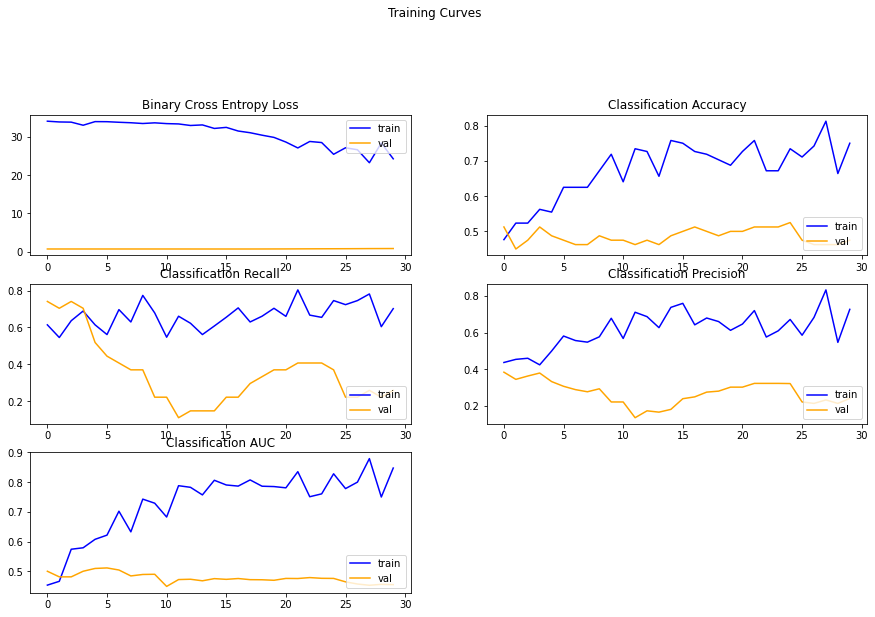

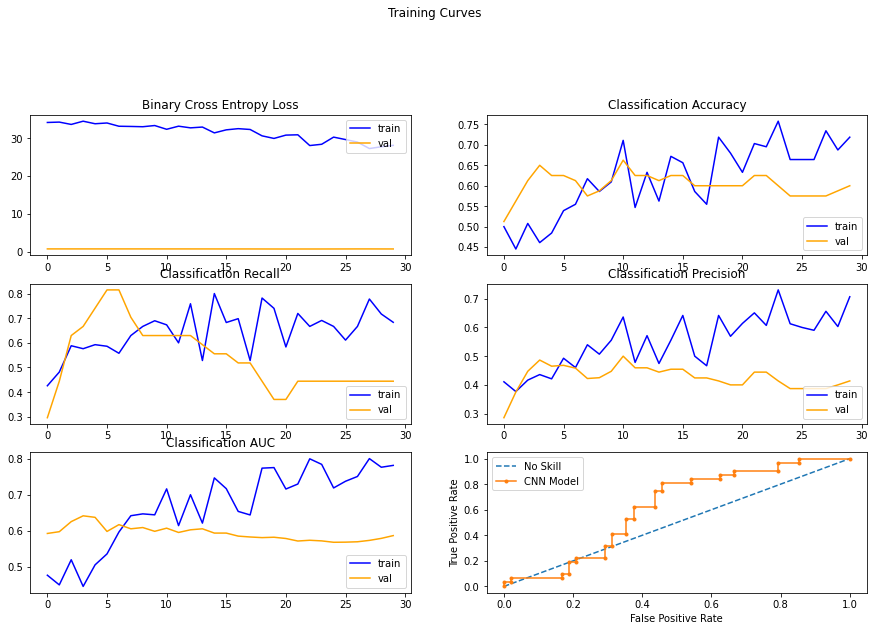

0.6171875 AUC
Best Threshold=0.368265, G-Mean=1.354

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 238 238
Initial validation set 82 82
Initial test set 80 80
Initial test set: Negative samples: 56 || Positive samples: 24 || Total_samples: 80
Initial validation set: Negative samples: 56 || Positive samples: 26 || Total_samples: 82
(82, 32, 32, 3)
(82, 100, 100, 3)
(80, 32, 32, 3)
(80, 100, 100, 3)
Initial train set contains 74 covid samples and 164 non-covid samples
Train set in use: Number of negatives: 82 || Number of positives: 74
w_0: 47.43589743589744
w_1: 52.56410256410256
(156, 32, 32, 3)
(156, 100, 100, 3)
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output S

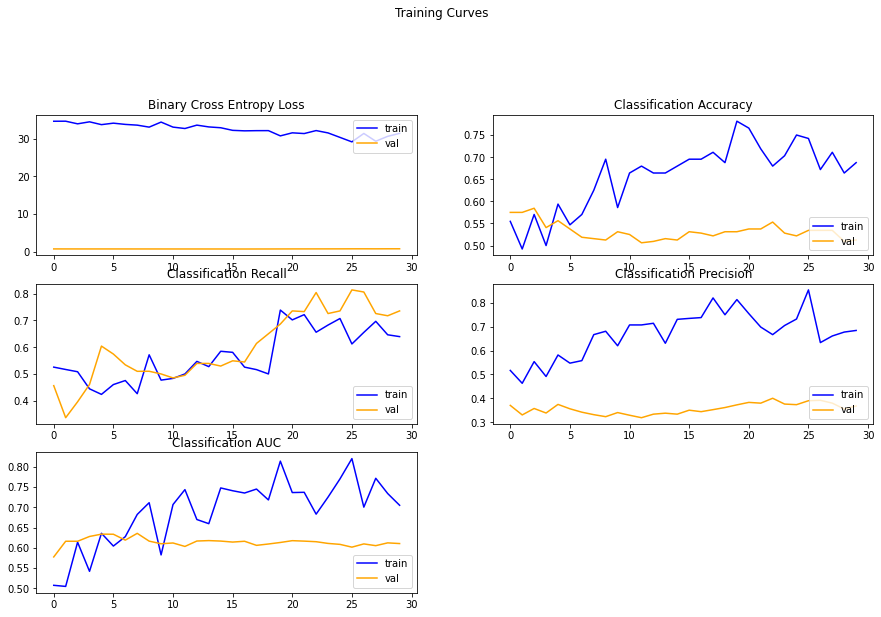

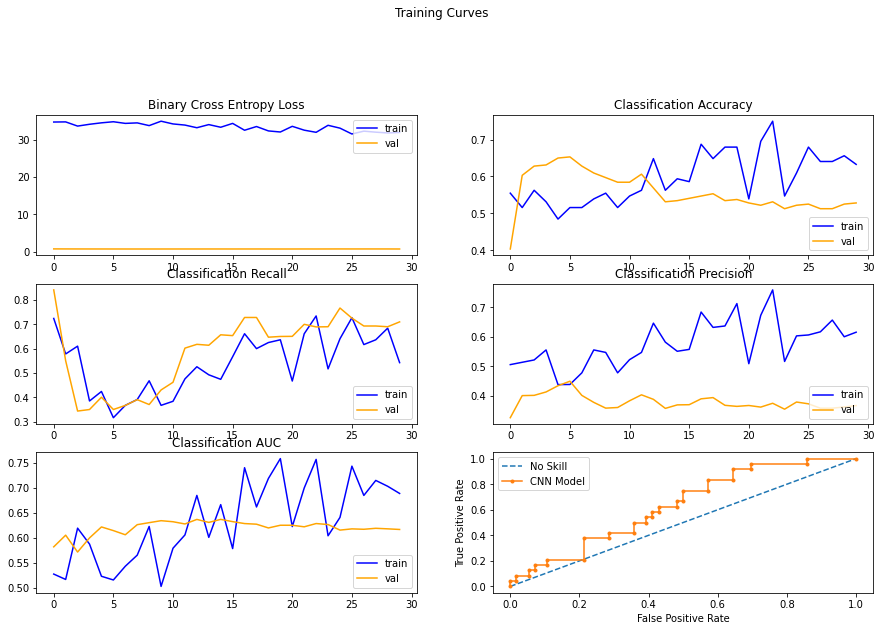

0.6331845238095238 AUC
Best Threshold=0.366111, G-Mean=1.274

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 242 242
Initial validation set 80 80
Initial test set 78 78
Initial test set: Negative samples: 63 || Positive samples: 15 || Total_samples: 78
Initial validation set: Negative samples: 48 || Positive samples: 32 || Total_samples: 80
(80, 32, 32, 3)
(80, 100, 100, 3)
(78, 32, 32, 3)
(78, 100, 100, 3)
Initial train set contains 77 covid samples and 165 non-covid samples
Train set in use: Number of negatives: 82 || Number of positives: 77
w_0: 48.42767295597484
w_1: 51.57232704402516
(159, 32, 32, 3)
(159, 100, 100, 3)
Model: "sequential_73"
_________________________________________________________________
Layer (type)                

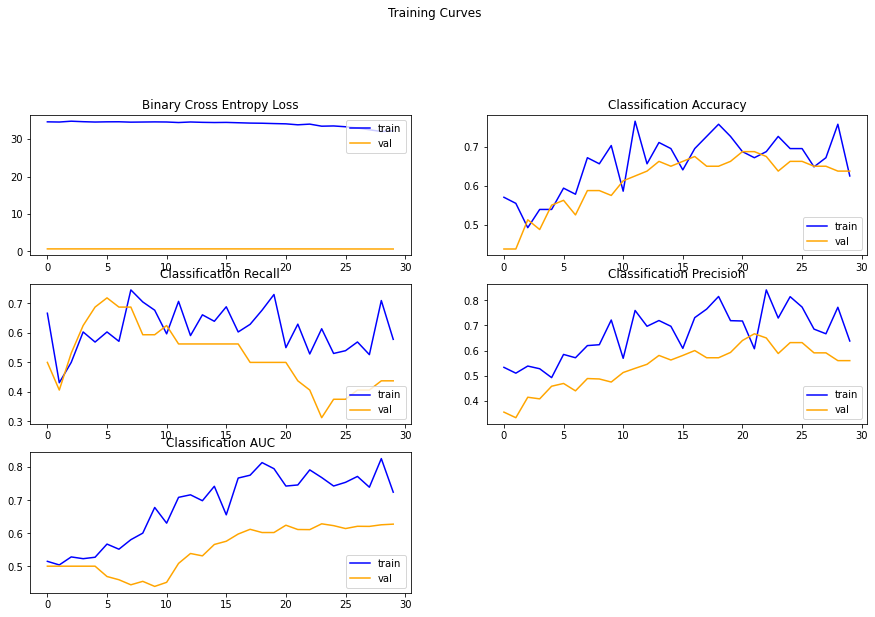

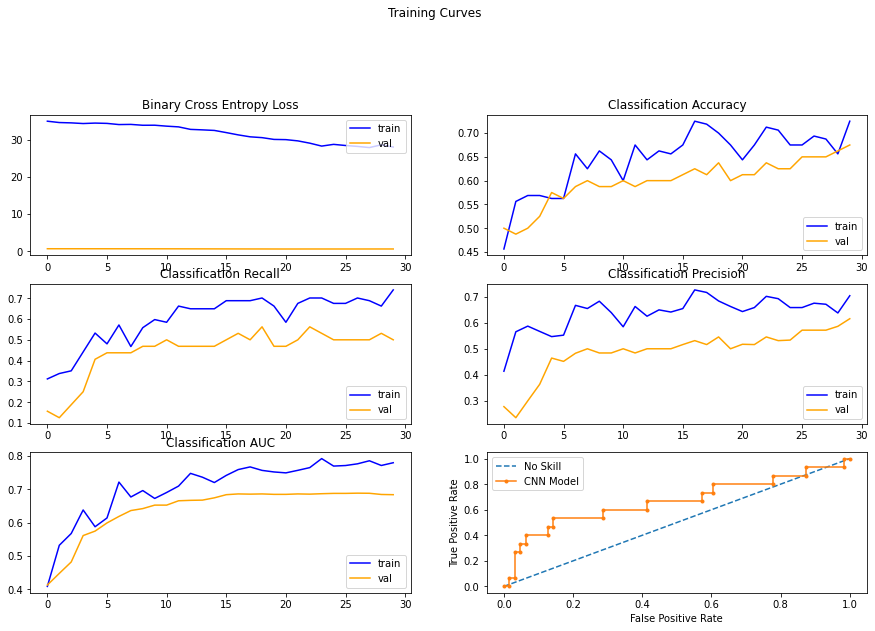

0.6666666666666666 AUC
Best Threshold=0.551080, G-Mean=1.390

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Accuracy: 61.791 %
Recall: 56.2347 %
Precision: 40.4306 %
AUC: 64.8099 %
Specificity: 64.0016 %


In [ ]:
threshold = 0.5
PRED, ACTUAL = train_with_5_folds_ensemble(splitted_folds)

## Hosmer-Lemeshow test
`data.json` files contain predicted and actual values for each sample of the test set, for each one of the five different splits of the dataset resulting from the 5-fold cross validation. These values are given as input to the following R code, to calculate the Hosmer-Lemeshow test statistic of the model.


```
library(ResourceSelection)
hl <- hoslem.test(x, y, g=10)
hl          
```

where x contains the predicted values and y the actual values of one of the 5 iterations

In [ ]:
y_pred = []
for i in ACTUAL:
  preds = []
  for j in i:
    preds.append(j[0])
  y_pred.append(preds)

In [ ]:
prs = []
for j in range(5):
  tmp2 = []
  tmp1 = calculate_mean_probabilities(PRED[j])
  pr = get_total_predictions(tmp1, 0.5)
  prs.append(list(pr))

In [ ]:
mydict = {"Predicted": prs[0], "Actual": y_pred[0]}
with open('data1.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[1], "Actual": y_pred[1]}
with open('data2.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[2], "Actual": y_pred[2]}
with open('data3.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[3], "Actual": y_pred[3]}
with open('data4.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[4], "Actual": y_pred[4]}
with open('data5.json', 'w') as fp:
    json.dump(str(mydict), fp)